In [1]:
import dill

# dill.dump_session('Sessions/analyse_statistique_P7_19-06.db')
dill.load_session('Sessions/analyse_statistique_P7_19-06.db')

In [2]:
import sys
import os
from time import time
import copy

import pandas as pd
pd.set_option("display.max_columns", 100)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from matplotlib.patches import ConnectionPatch
# from matplotlib.lines import Line2D
csfont = {'fontname':'Nexa Bold'} # Tuning font for plots

import seaborn as sns
sns.set()

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, roc_auc_score
from sklearn.metrics import log_loss, f1_score

from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.cluster import KMeans
from scipy.misc import derivative

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

import lime
import lime.lime_tabular

import shap

import gc
import umap
import missingno as msno

import streamlit

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# from flask import Flask, render_template

# app = Flask(__name__)

# @app.route('/')
# def hello():
#     return "Hello world !"

# @app.route('/dashboard/')
# def dashboard():
#     return render_template("dashboard.html")

# if __name__ == "__main__":
#     app.run()

Les fichiers d'entraînement et de test contiennent les informations relatives aux crédits accordés à chaque client.  

Le fichier d'entraînement comporte une colonne TARGET qui vaut 0 ou 1 si le crédit a été remboursé dans les temps ou non respectivement. Le but du projet est de prédire avec le jeu test ce que vaut cette TARGET (principal indicateur) et de créer un dashboard plus complet, avec d'autres KPIs, pour informer les chargés de clientèle et aussi les clients sur leur situation, pour comprendre/expliquer les raisons qui amènent la banque à accorder un nouveau crédit ou non.  

La première partie d'analyse des données et de feature engineering provient en grande partie d'un kernel présent sur le site Kaggle, comme demandé dans l'énoncé. Le but de ce projet est effectivement de créer un modèle de prédiction et un dashboard interactif, sans passer trop de temps sur l'analyse exploratoire.  

En résumé, cette analyse comprend la jointure des tables utiles au modèle ainsi que le feature engineering en regardant l'importance des features dans un premier modèle pour restreindre leur nombre et éviter le fléau de la dimensionnalité.  

Dans la deuxième partie, nous testons plusieurs modèles de classification binaire et plusieurs métriques avant de sélectionner la meilleure solution.

# Analyse exploratoire

## Fonctions

### missing_values_table

In [2]:
def missing_values_table(df):
    """
    Function to calculate missing values by column.
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

### remove_missing_columns

In [3]:
def remove_missing_columns(train, test, threshold = 90):
    """
    Calculate missing stats for train and test (remember to calculate a percent!).
    """
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

### kde_target

In [4]:
def kde_target(var_name, df):
    """
    Plot the distribution of a variable colored by value of the target.
    """
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize=(10,5))
    
    # Plot the distribution for target = 0 and target = 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET = 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET = 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

### agg_numeric

In [5]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [6]:
# # OLD #
# def agg_numeric(df, group_var, df_name):
#     """
#     Aggregates the numeric values in a dataframe. This can be used to create features 
#     for each instance of the grouping variable.
    
#     Parameters
#     --------
#         df (dataframe): 
#             the dataframe to calculate the statistics on
#         group_var (string): 
#             the variable by which to group df
#         df_name (string): 
#             the variable used to rename the columns
        
#     Return
#     --------
#         agg (dataframe): 
#             a dataframe with the statistics aggregated for 
#             all numeric columns. Each instance of the grouping variable will have 
#             the statistics (mean, min, max, sum; currently supported) calculated. 
#             The columns are also renamed to keep track of features created.
    
#     """
#     # Remove id variables other than grouping variable
#     for col in df:
#         if col != group_var and 'SK_ID' in col:
#             df = df.drop(columns = col)
            
#     group_ids = df[group_var]
#     numeric_df = df.select_dtypes('number')
#     numeric_df[group_var] = group_ids

#     # Group by the specified variable and calculate the statistics
#     agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

#     # Need to create new column names
#     columns = [group_var]

#     # Iterate through the variables names
#     for var in agg.columns.levels[0]:
#         # Skip the grouping variable
#         if var != group_var:
#             # Iterate through the stat names
#             for stat in agg.columns.levels[1][:-1]:
#                 # Make a new column name for the variable and stat
#                 columns.append('%s_%s_%s' % (df_name, var, stat))

#     agg.columns = columns
#     return agg

### agg_categorical

In [7]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

### count_categorical

In [8]:
def count_categorical(df, group_var, df_name):
    """
    Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

### aggregate_client

In [9]:
def aggregate_client(df, group_vars, df_names):
    """
    Aggregate a dataframe with data at the loan level at the client level.
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

### target_corrs

In [10]:
def target_corrs(df):
    """
    Function to calculate correlations with the target for a dataframe.
    """
    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

### convert_types

In [11]:
def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

## Construction du jeu de données

### bureau / bureau_balance

In [ ]:
# Training data
train = pd.read_csv('Fichiers/application_train.csv')
print('Training data shape: ', train.shape)
train.head()

In [ ]:
# Testing data features
test = pd.read_csv('Fichiers/application_test.csv')
print('Testing data shape: ', test.shape)
test.head()

In [ ]:
train['TARGET'].value_counts()

In [ ]:
train['TARGET'].astype(int).plot.hist();

La target n'est pas équilibrée du tout (90/10), il faut prendre cela en compte dans les modèles en pondérant chaque réponse.

In [ ]:
# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(5)

In [ ]:
# Read in bureau
bureau = pd.read_csv('Fichiers/bureau.csv')
bureau.head()

On fait un groupby pour avoir le nombre de crédits précédents pour un client :

In [ ]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count()\
                        .rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

In [ ]:
# Join to the training dataframe
train = pd.read_csv('Fichiers/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

In [ ]:
# Graph : distribution of EXT_SOURCE_3
plt.style.use('fivethirtyeight')
kde_target('EXT_SOURCE_3', train)

In [ ]:
# Graph : distribution of previous_loan_counts
kde_target('previous_loan_counts', train)

In [ ]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False)\
            .agg(['count','mean','max','min','sum']).reset_index()
bureau_agg.head()

On transforme ce dataframe multi-level en dataframe simple :

In [ ]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [ ]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

On merge ce dataframe au principal avec le SK_ID_CURR :

In [ ]:
# Merge with the training data
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train.head()

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

In [ ]:
train = train.merge(bureau_counts, left_on='SK_ID_CURR', right_index=True, how='left')
train.head()

In [ ]:
train.shape

In [ ]:
# Read in bureau balance
bureau_balance = pd.read_csv('Fichiers/bureau_balance.csv')
bureau_balance.head()

Calculs pour chaque statut pour chaque crédit : 

In [ ]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

In [ ]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, parent_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

In [ ]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

In [ ]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(
    columns=['SK_ID_BUREAU']), parent_var='SK_ID_CURR', df_name='client')

bureau_balance_by_client.head()

### previous_app / POS / credit card / installments

In [ ]:
train = pd.read_csv('Fichiers/application_train.csv')
# train = pd.read_csv('Fichiers/train_bureau_raw.csv')
train = convert_types(train)

test = pd.read_csv('Fichiers/application_test.csv')
# test = pd.read_csv('Fichiers/test_bureau_raw.csv')
test = convert_types(test)

In [ ]:
train = train.iloc[:1000,:]
test = test.iloc[:1000,:]

In [ ]:
previous = pd.read_csv('Fichiers/previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head(5)

In [ ]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head(5)

In [ ]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

In [ ]:
# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
cash = pd.read_csv('Fichiers/POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
cash.head()

In [ ]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

In [ ]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
credit = pd.read_csv('Fichiers/credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()

In [ ]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

In [ ]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
installments = pd.read_csv('Fichiers/installments_payments.csv')
installments = convert_types(installments, print_info = True)
installments.head()

In [ ]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], 
                                          df_names = ['installments', 'client'])
installments_by_client.head()

In [ ]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

In [ ]:
print(f'Final training size: {return_size(train)}')
print(f'Final testing size: {return_size(test)}')

In [ ]:
# train.to_csv('Fichiers/train_previous_raw.csv', index = False, chunksize = 500)
# test.to_csv('Fichiers/test_previous_raw.csv', index = False)

train.to_csv('Fichiers/train_previous_1000.csv', index = False)
test.to_csv('Fichiers/test_previous_1000.csv', index = False)

In [ ]:
train = pd.read_csv('Fichiers/train_previous_1000.csv')
test = pd.read_csv('Fichiers/test_previous_1000.csv')

In [ ]:
submission, fi, metrics = run_LGBM(train, test)

In [ ]:
metrics

In [ ]:
submission

In [ ]:
plot_feature_importances(fi)

### Pipeline

#### bureau / bureau_balance

In [ ]:
# Read data
train = pd.read_csv('Fichiers/application_train.csv')
test = pd.read_csv('Fichiers/application_test.csv')
bureau = pd.read_csv('Fichiers/bureau.csv')
bureau_balance = pd.read_csv('Fichiers/bureau_balance.csv')

In [ ]:
# Counts of Bureau dataframe
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')

# Aggregated stats of bureau dataframe
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), parent_var = 'SK_ID_CURR', df_name = 'bureau')

# Value counts of Bureau Balance dataframe by loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

# Aggregated stats of Bureau Balance dataframe by loan
bureau_balance_agg = agg_numeric(bureau_balance, parent_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

# Aggregated Stats of Bureau Balance by Client
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, 
                                          left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), 
                                       parent_var = 'SK_ID_CURR', df_name = 'client')

In [ ]:
# Insert Computed Features into Training Data
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

On applique les mêmes fusion de dataframe au jeu de test et on l'aligne avec le jeu d'entrainement pour être sûr d'avoir les mêmes colonnes (sauf la colonne TARGET qui ne se trouve que dans train).

In [ ]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on='SK_ID_CURR', how='left')
test = test.merge(bureau_counts, on='SK_ID_CURR', how='left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
test = test.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')
test = test.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')

In [ ]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

In [ ]:
# Get labels
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

# Replace labels
train['TARGET'] = train_labels

In [ ]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

In [ ]:
# Free up memory by deleting old objects
import gc
gc.enable()
del bureau, bureau_balance, bureau_agg, bureau_balance_agg, \
bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

#### previous_app / POS / credit card / installments 

In [ ]:
train = convert_types(train)
test = convert_types(test)

In [ ]:
previous = pd.read_csv('Fichiers/previous_application.csv')
previous = convert_types(previous, print_info=True)

In [ ]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)

In [ ]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)

In [ ]:
# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
cash = pd.read_csv('Fichiers/POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)

In [ ]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])

In [ ]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
credit = pd.read_csv('Fichiers/credit_card_balance.csv')
credit = convert_types(credit, print_info = True)

In [ ]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])


In [ ]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
installments = pd.read_csv('Fichiers/installments_payments.csv')
installments = convert_types(installments, print_info = True)

In [ ]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], 
                                          df_names = ['installments', 'client'])

In [ ]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

In [ ]:
# Save files
train.to_csv('Fichiers/train_all_merged.csv', index = False, chunksize = 500)
test.to_csv('Fichiers/test_all_merged.csv', index = False)

## Feature engineering

### bureau / bureau_balance

#### Missing values

In [ ]:
missing_train = missing_values_table(train)
missing_train.head(5)

In [ ]:
# Columns with more than 90% of missing values
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

In [ ]:
missing_test = missing_values_table(test)
missing_test.head(5)

In [ ]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

In [ ]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing values in either the training or testing data.'\
      % len(missing_columns))

In [ ]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [ ]:
# Save train and test dataframes into csv files
train.to_csv('Fichiers/train_bureau_raw.csv', index = False)
test.to_csv('Fichiers/test_bureau_raw.csv', index = False)

#### Correlations

In [ ]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [ ]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

In [ ]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

#### Collinear variables

On supprime les variables qui sont trop corrélées entre elles (une variable sur les deux) avec un certain seuil (0.8 par ex.)

In [ ]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [ ]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

In [ ]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

In [ ]:
# Save new dataframes into files
train_corrs_removed.to_csv('Fichiers/train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('Fichiers/test_bureau_corrs_removed.csv', index = False)

### all merged

In [367]:
train = pd.read_csv('Fichiers/train_all_merged.csv')
test = pd.read_csv('Fichiers/test_all_merged.csv')

In [368]:
train, test = remove_missing_columns(train, test, threshold=30)

There are 500 columns with greater than 30% missing values.


In [369]:
train.shape

(307511, 820)

In [63]:
# pick 10000 first rows
train = train.iloc[:10000,:]

In [388]:
# pick 10000 random rows
train = train.sample(n=10000, axis=0)
train.shape

(307511, 820)

In [400]:
# Picking random samples of train data 
# Proceeding to correlations between all variables for each pick
# Saving the mean correlation dataframe into 'corrs'

dfs = []
corrs = pd.DataFrame()
for i in range(5):
    dfs.append(train.sample(n=10000, axis=0).corr())

corrs = (dfs[0] + dfs[1] + dfs[2] + dfs[3] + dfs[4]) / 5
corrs.head()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR          1.000000     -0.003577         -0.005824    0.002108   
CNT_CHILDREN       -0.003577      1.000000          0.021081   -0.004922   
AMT_INCOME_TOTAL   -0.005824      0.021081          1.000000    0.260862   
AMT_CREDIT          0.002108     -0.004922          0.260862    1.000000   
AMT_ANNUITY         0.002597      0.012126          0.326493    0.765416   

                  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
SK_ID_CURR           0.002597         0.003355                   -0.003939   
CNT_CHILDREN         0.012126        -0.008298                   -0.030392   
AMT_INCOME_TOTAL     0.326493         0.265507                    0.128808   
AMT_CREDIT           0.765416         0.986811                    0.092028   
AMT_ANNUITY          1.000000         0.770438                    0.112909   

                  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
SK_ID_CURR         -0.004024       0.005829          -0.002551   
CNT_CHILDREN        0.322595      -0.232590           0.175282   
AMT_INCOME_TOTAL    0.038994      -0.104912           0.048507   
AMT_CREDIT         -0.059065      -0.060708           0.008827   
AMT_ANNUITY         0.002386      -0.096162           0.036576   

                  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
SK_ID_CURR               0.001732         NaN       -0.005745   
CNT_CHILDREN            -0.030489         NaN        0.233474   
AMT_INCOME_TOTAL         0.010578         NaN        0.104547   
AMT_CREDIT              -0.007171         NaN        0.059323   
AMT_ANNUITY              0.008503         NaN        0.095368   

                  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR               0.001858          0.003882    0.007217   -0.002554   
CNT_CHILDREN             0.064231          0.004973   -0.025660    0.022067   
AMT_INCOME_TOTAL        -0.030061         -0.018865   -0.000129    0.064280   
AMT_CREDIT              -0.019869          0.017149    0.023364    0.023683   
AMT_ANNUITY             -0.028488          0.015441    0.005211    0.075156   

                  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR              -0.002190              0.001270   
CNT_CHILDREN             0.881753              0.026326   
AMT_INCOME_TOTAL         0.027488             -0.144878   
AMT_CREDIT               0.055984             -0.093858   
AMT_ANNUITY              0.066553             -0.126187   

                  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                           0.002913                -0.000845   
CNT_CHILDREN                         0.025792                -0.002419   
AMT_INCOME_TOTAL                    -0.156188                 0.065995   
AMT_CREDIT                          -0.101834                 0.051809   
AMT_ANNUITY                         -0.139759                 0.052816   

                  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                         -0.004583                   -0.005456   
CNT_CHILDREN                       -0.017779                    0.009089   
AMT_INCOME_TOTAL                    0.054395                    0.104412   
AMT_CREDIT                          0.025762                    0.051572   
AMT_ANNUITY                         0.042413                    0.083473   

                  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                          -0.005196               -0.002275   
CNT_CHILDREN                         0.017804                0.017930   
AMT_INCOME_TOTAL                     0.096083                0.003901   
AMT_CREDIT                           0.051885               -0.030451   
AMT_ANNUITY                          0.080298               -0.007792   

                  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
SK_ID_CURR                     -0.004976                -0.00316

#### Correlations

In [323]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [324]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

TARGET
TARGET                                      1.000000
previous_NAME_CONTRACT_STATUS_Refused_mean  0.086703
previous_CODE_REJECT_REASON_SCOFR_mean      0.085954
DAYS_BIRTH                                  0.083504
previous_NAME_CONTRACT_STATUS_Refused_sum   0.079764
previous_CODE_REJECT_REASON_SCOFR_sum       0.077117
bureau_DAYS_CREDIT_mean                     0.075516
bureau_CREDIT_ACTIVE_Active_count_norm      0.075280
bureau_DAYS_CREDIT_ENDDATE_mean             0.073770
previous_NAME_PRODUCT_TYPE_walk-in_sum      0.071061

In [325]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

TARGET
previous_CHANNEL_TYPE_Stone_mean            -0.045312
previous_RATE_DOWN_PAYMENT_max              -0.045875
previous_HOUR_APPR_PROCESS_START_min        -0.046449
client_installments_AMT_PAYMENT_min_sum     -0.049243
previous_HOUR_APPR_PROCESS_START_mean       -0.049729
bureau_CREDIT_ACTIVE_Closed_count_norm      -0.075437
previous_CODE_REJECT_REASON_XAP_mean        -0.083584
previous_NAME_CONTRACT_STATUS_Approved_mean -0.083640
EXT_SOURCE_2                                -0.165660
EXT_SOURCE_3                                -0.177535

#### Collinear variables

In [401]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [402]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  338


In [403]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 482)
Testing Corrs Removed Shape:  (48744, 481)


In [405]:
# pick 50000 random rows
train_sample = train_corrs_removed.sample(n=50000, axis=0)

In [406]:
# Save files
train_sample.to_csv('Fichiers/train_all_merged_mean_corrs_removed_random_50000.csv', index = False)
test_corrs_removed.to_csv('Fichiers/test_all_merged_mean_corrs_removed.csv', index = False)

# Modélisation

## Fonctions

### run_LGBM

In [12]:
def run_LGBM(features, test_features, encoding='ohe', n_folds=5):
    """
    Train and test a light gradient boosting model using cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use for training a model. 
            Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' 
            for one-hot encoding or 'le' for integer label encoding
        n_folds (int, default = 5): 
            number of folds to use for cross validation
        
    Return
    --------
        predictions (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model for test data.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    t0 = time()
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    print('Before encoding :\n')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    
    print('After encoding :\n')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    valid_pred = []
    valid_proba = []
    test_pred = []
    test_proba = []
    
    global probas
    probas = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        y_pred = model.predict(valid_features, num_iteration = best_iteration)
        valid_pred.append(y_pred)
        valid_proba.append(model.predict_proba(valid_features)[:, 1])
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        probas.append(model.predict_proba(test_features, num_iteration = best_iteration))
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
    
        
    # Make the submission dataframe
    predictions = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
#     valid_auc = roc_auc_score(labels, out_of_fold)  # ERROR ?
    
    # Add the overall scores to the metrics
#     valid_scores.append(valid_auc)  # cf previous error (?)
    valid_scores.append(np.mean(valid_scores))
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('mean')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    duration = time() - t0
    print('\nDone in %imin %.3fs' % (duration/60, duration%60))
    return predictions, feature_importances, metrics

### run_XGBOOST

In [13]:
def run_XGBOOST(features, test_features, encoding='ohe', n_folds=5):
    """
    Train and test a xgboost model using cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use for training a model. 
            Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' 
            for one-hot encoding or 'le' for integer label encoding
        n_folds (int, default = 5): 
            number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    t0 = time()
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    print('Before encoding :\n')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
    
    print('After encoding :\n')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Convert test data into DMatrix
    dtest = xgb.DMatrix(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    global probas
    probas = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Convert data into DMatrix
        dtrain = xgb.DMatrix(train_features, label=train_labels)
        dvalid = xgb.DMatrix(valid_features, label=valid_labels)
        
        # Parameters
        params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric':'auc'}
        
        # Train and valid data
        evals = [(dvalid, 'eval'), (dtrain, 'train')]
        
        # Create the model
        num_round = 10
        bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=100)
#         bst.save_model('0001.model')
        
        # Record the best iteration
        best_iteration = bst.best_iteration
        
        # Record the feature importances
#         feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
#         test_predictions += bst.predict(dtest, ntree_limit=bst.best_ntree_limit)[:, 1] / k_fold.n_splits
        test_predictions += bst.predict(dtest, ntree_limit=bst.best_ntree_limit) / k_fold.n_splits
        probas.append(bst.predict(dtest, ntree_limit=bst.best_ntree_limit))
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit) #[:, 1]
        
        # Record the best score
        valid_score = bst.best_score #['valid'] #['auc']
#         train_score = bst.best_score #['train'] #['auc']
        
        valid_scores.append(valid_score)
#         train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        #del model 
        del train_features, valid_features
        gc.collect()
    
    xgb.plot_importance(bst)
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
#     feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
#     train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            #'train': train_scores,
                            'valid': valid_scores}) 
    
    duration = time() - t0
    print('\nDone in %imin %.3fs' % (duration/60, duration%60))
    return submission, metrics

### plot_feature_importances

In [14]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize =(10,6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
#     ax.barh(list(reversed(list(df.index[:15]))), 
#             df['importance_normalized'].head(15), 
#             align = 'center', edgecolor = 'k')
    
    #Variables
    counts = np.array(df['importance_normalized'].head(15))
    names = np.array(df['feature'].head(15))

    #Plot
    sns.barplot(counts, names, palette='summer')

    # Set the yticks and labels
    # ax.set_yticks(list(reversed(list(df.index[:15]))))
    # ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances', fontsize=16, pad=15, **csfont)
    plt.show()
    
#     return df

### benchmark_classifiers

In [25]:
def benchmark_classifiers(features, test_features, encoding='ohe', resample=None, NaN_thresh=90):
    """
    Train and test a light gradient boosting model using cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use for training a model. 
            Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' 
            for one-hot encoding or 'le' for integer label encoding
        resample (str, default = None): 
            model to resample the umbalanced data. 
            Models available : 'SMOTE': oversampling method
                               'RUS': random undersampling
                               'CC': clusters centroids undersampling
        NaN_thresh (float or int, default=90)
            threshold (%) of NaNs to remove the column
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    t0 = time()
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    y = features['TARGET']
    
    # Weights of positive targets assigned if data are not resampled
    if resample is not None:
        pos_weight = None
        class_weights = None
    else:
        pos_weight = np.round(features['TARGET'].value_counts()[0]/features['TARGET'].value_counts()[1])
        class_weights = [1, pos_weight]
    print('Positive weight :', pos_weight)
    print()
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    # Shapes of data
    print('Before cleaning NaNs :')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # Remove columns with any NaN
#     features.dropna(how='any', axis=1, inplace=True)
#     test_features.dropna(how='any', axis=1, inplace=True)
    
    # Remove columns whose % of NaNs is greater than a threshold (NaN_thresh)
    features, test_features = remove_missing_columns(features, test_features, threshold = NaN_thresh)
    
    # Impute NaNs by mean of column
#     features.fillna(features.mean(), inplace=True)
#     test_features.fillna(test_features.mean(), inplace=True)
    
    # Impute NaNs by median of column
    features.fillna(features.median(), inplace=True)
    test_features.fillna(test_features.median(), inplace=True)

    # Shapes of data
    print('After cleaning NaNs :')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join='inner', axis=1)
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    # Shapes of data
    print('After encoding :')
    print('Training shape: ', features.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    # Extract feature names
    global feature_names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Benchmark of classifiers
    global clf_names
    clf_names = [#"KNN", "Linear SVM", "RBF SVM", 
#                  "Gaussian Process",
#                  "Decision Tree", 
#                  "Random Forest",
#                  "Neural Net", "AdaBoost", 
#                  "Naive Bayes", "QDA",
                 "XGBoost",
                 "LGBM",
                 "CatBoost"
            ]

    classifiers = [
#         GridSearchCV(KNeighborsClassifier(), param_grid=[{'n_neighbors':range(3,10)}]),
#         GridSearchCV(SVC(kernel="linear", probability=True), param_grid=[{'C':[0.025,0.05,0.1]}]),
#         GridSearchCV(SVC(probability=True), param_grid=[{'gamma':[1,2,3],'C':[0.1,1,2]}]),
#         GaussianProcessClassifier(1.0 * RBF(1.0)),
#         DecisionTreeClassifier(max_depth=2, min_samples_split=2),
# #                      param_grid=[{'max_depth':[2,5,8],'min_samples_split':[1,2]}]),
#         RandomForestClassifier(max_depth=2, max_features=1, n_estimators=10),
# #                      param_grid=[{'max_depth':[2,5,8],'n_estimators':[10,50,100],'max_features':[1,2]}]),
#         MLPClassifier(alpha=2, max_iter=1000),
# #                      param_grid=[{'alpha':[2,3,5],'max_iter':[1000,2000,3000]}]),
#         AdaBoostClassifier(), 
# #                      param_grid=[{'n_estimators':[10,50,100], 'learning_rate':[0.1,1]}])
#         GaussianNB(),
#         QuadraticDiscriminantAnalysis(), 
        XGBClassifier(max_depth=4, eta=0.01, n_estimators=100, 
                      objective='binary:logistic', scale_pos_weight=pos_weight), 
#                      param_grid=[{'max_depth':[4,8], 'eta':[0.01,0.1,1], 'objective':['binary:logistic'],
#                                  'n_estimators':[100, 1000],'scale_pos_weight':[pos_weight]}]),
        lgb.LGBMClassifier(n_estimators=10000, 
                           objective = 'binary', # 'binary', logloss_obj
                           class_weight = 'balanced', 
                           scale_pos_weight = pos_weight,
                           learning_rate = 0.05, 
                           reg_alpha = 0.1, reg_lambda = 0.1, 
                           #max_depth = 5,
                           subsample = 0.8, n_jobs = -1, random_state = 50),
        CatBoostClassifier(iterations=10,
                           depth=3,
                           learning_rate=0.1,
                           loss_function='Logloss',
                           #objective = logloss_obj,
                           #eval_metric = logloss_eval,
                           class_weights=class_weights,
                           verbose=True)
    ]
    
    # Separating data into train and valid sets
    global X_train, X_valid, y_train, y_valid
    global test_norm
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(features)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=.7, random_state=42)
    
    # return encoded and normalized test data
    test_norm = scaler.fit_transform(test_features)
    
    # Rebalance imbalanced class through oversampling
    print('Resampling model :', resample)
    if resample=='SMOTE':
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    
    # Rebalance imbalanced class through undersampling
    if resample=='RUS':
        undersampling = RandomUnderSampler(random_state=42)
        X_train, y_train = undersampling.fit_resample(X_train, y_train)

    if resample=='CC':
        undersampling = ClusterCentroids(random_state=42)
        X_train, y_train = undersampling.fit_resample(X_train, y_train)

    # Shapes of data
    if resample==None:
        print('After separating data:')
    else:
        print('After separating and resampling data:')
    print('Training shape: ', X_train.shape)
    print('Validating shape: ', X_valid.shape)
    print('Testing shape: ', test_features.shape)
    print()
    
    valid_scores = []
    valid_pred = []
    valid_proba = []
    test_pred = []
    test_proba = []
    log_loss_scores = []
    roc_auc_scores = []
    
    # Dict of model (fitted on train data)
    global models
    models = {}
    
    # iterate over classifiers
    for name, clf in zip(clf_names, classifiers):
        if name=='LGBM':
            model= clf.fit(X_train, y_train, 
                           eval_metric = 'logloss', #'logloss', logloss_eval
                           eval_set = [(X_valid, y_valid)], eval_names = ['valid'], 
                           categorical_feature = 'auto', #cat_indices,
                           early_stopping_rounds = 100, verbose = 200)
        elif name=='XGBoost':
            model= clf.fit(X_train, y_train, eval_metric = 'logloss',
                           eval_set = [(X_valid, y_valid)],
                           early_stopping_rounds = 100, verbose = False)
        elif name=='CatBoost':
            model= clf.fit(X_train, y_train,
                           eval_set = [(X_valid, y_valid)],
                           verbose = True)    
        else:
            model = clf.fit(X_train, y_train)
            
        models[name]= model
        y_pred = model.predict(X_valid)
        score = accuracy_score(y_valid, y_pred)
#         score = clf.score(y_pred, y_valid)
        valid_scores.append(score)
    
        valid_pred.append(y_pred)
        valid_proba.append(model.predict_proba(X_valid)[:, 1])

        # predictions on test data
        test_pred.append(model.predict(test_features))
        test_proba.append(model.predict_proba(test_features)[:, 1])
        
        # log loss function
        log_loss_scores.append(log_loss(y_valid, model.predict_proba(X_valid)[:, 1]))
        
        # ROC curve and AUC
        global fpr, tpr, thresholds
        fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
        roc_auc_scores.append(roc_auc_score(y_valid, y_pred))
        
        # display best estimator from Cross Validation
#         print('Best parameters for {} : \n {}'.format(name, clf.best_estimator_))

    # Dataframe of classifiers scores  
    scores_df = pd.DataFrame(np.round(valid_scores,3), columns=['Valid Accuracy'], index=[clf_names])
    scores_df['Log_loss'] = np.round(log_loss_scores,3)
    scores_df['AUC'] = np.round(roc_auc_scores,3)
    
    # Predictions dataframe
    predictions = pd.DataFrame({'SK_ID_CURR': test_ids, 
                                str(clf_names[0]): test_pred[0],
                                str(clf_names[0])+' (proba)': test_proba[0],
                                str(clf_names[1]): test_pred[1],
                                str(clf_names[1])+' (proba)': test_proba[1],
                                str(clf_names[2]): test_pred[2],
                                str(clf_names[2])+' (proba)': test_proba[2]
                               })

    duration = time() - t0
    print('\nDone in %imin %.1fs' % (duration/60, duration%60))
    
#     return scores_df, valid_pred, test_pred, valid_proba, test_proba
    return predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba

### custom objective / eval functions

#### test

In [16]:
def custom_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*0.1*residual, -2*residual)
    hess = np.where(residual<0, 2*0.1, 2.0)
    return grad, hess

def custom_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual<0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

#### logloss

In [17]:
# Best scores for LGBM not resampled : (first formulae)
#beta = 10
#beta_h = 2

def logloss_obj(y_true, y_pred):
    y_pred = 1. / (1. + np.exp(-y_pred)) # convert y_pred into proba
    beta = 4
    beta_h = 2.
    
    # first formulae
#     grad = beta * (y_pred - y_true)
#     hess = beta_h * y_pred * (1.0 - y_pred)
    
    # second formulae
    grad = y_pred * ((beta-1) * y_true + 1) - beta * y_true
    hess = ((beta - 1) * y_true + 1) * y_pred * (1.0 - y_pred)
    
    return grad, hess

def logloss_eval(y_true, y_pred):
#     y_pred = np.clip(y_pred, 10e-7, 1-10e-7)
    y_pred = 1. / (1. + np.exp(-y_pred))
    loss_fn = y_true*np.log(y_pred)
    loss_fp = (1.0 - y_true)*np.log(1.0 - y_pred)
    loss = np.sum(-(10*loss_fn+loss_fp))/len(y_true)
    return 'custom logloss', loss, False

#### focal loss

In [18]:
def focal_loss_lgb(y_true, y_pred, alpha, gamma):
    a,g = alpha, gamma
#     y_true = dtrain.label
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess

def focal_loss_lgb_eval_error(y_true, y_pred, alpha, gamma):
    a,g = alpha, gamma
#     y_true = dtrain.label
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) \
           * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    # (eval_name, eval_result, is_higher_better)
    return 'focal_loss', np.mean(loss), False

def focal_loss_lgb_f1_score(y_true, y_pred):
#     y_pred = predict_proba(y_pred)
    binary_pred = [int(p>0.5) for p in y_pred]
    return 'f1', f1_score(y_true, binary_pred), True

In [19]:
focal_loss = lambda x,y: focal_loss_lgb(x, y, alpha=0.25, gamma=2.)
focal_loss_eval = lambda x,y: focal_loss_lgb_eval_error(x, y, alpha=0.25, gamma=2.)
# model = lgb.train(best, self.lgtrain, fobj=focal_loss, feval=focal_loss_eval)

### plot_confusion_matrix

In [20]:
def plot_confusion_matrix(conf_matrix, name):
    """
    Plot the given confusion_matrix like a sns heatmap.
    Arg "name" is used in the graph title and file name.
    """
    fig = plt.figure(figsize=(10,5))

    #Heatmap
    ax = sns.heatmap(conf_matrix, square=True, cmap='Blues', lw=0.3, annot=True, fmt='d', cbar=None)

    # Fix the bottom and top half-cut problem
    b, t = plt.ylim() # top/bottom values
    b += 0.5 # add 0.5 to bottom
    t -= 0.5 # subtract 0.5 to top
    plt.ylim(b, t) # right dimensions

    # Add elements and save
    ax.set_xticklabels(target_names, fontsize=12, rotation=0, horizontalalignment='center')
    ax.set_yticklabels(target_names, fontsize=12, rotation=0)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')

    plt.title('Confusion matrix of {} predictions'.format(name), fontsize=18, pad=20, **csfont)
    plt.savefig(save_path+'ConfusionMatrix_{}.png'.format(name), dpi=200, bbox_inches='tight')
    plt.show()

### KMeans_loop

In [21]:
def KMeans_loop(X, range_n_clusters, KMeans_scores, save_path, proj=None):
    """
    Fonction pour faire une boucle de KMeans en faisant varier le nombre de clusters
    Trace pour chaque itération un graphe avec les scores silhouette et visualisation t-SNE du Kmeans 
    et calcule différents scores de clustering sauvegardés dans un dictionnaire
    
    Scores calculés : silhouette, Davies-Bouldin, Calinski-Harabasz
    Pour le score silhouette, on calcule la moyenne pour tous les clusters et celle de chaque cluster
    pour tracer le graphe de gauche

    Une boucle est réalisée à chaque itération pour vérifier la stabilité des scores (calcul de la std)
    Nombre d'itérations par défaut : 10
    
    Une projection des données en 2 dimensions est effectuée selon le choix de l'utilisateur pour visualiser 
    le clustering.
    
    Args :
        - X : variables d'entrée sur lesquelles effectuer le clustering
        - range_n_clusters : liste du nombre de clusters à tester
        - KMeans_scores : dictionnaire pour sauvegarder les scores
        - save_path : sauvegarde les graphes dans ce dossier
        - proj : type de projection des données en 2D (UMAP, t-SNE, PCA) - Aucune par défaut.
    """
    
    t0 = time()
    
    # projections choosen by user to visualize clustering
    if proj=='UMAP':
        reducer = umap.UMAP(random_state=42)
        X_umap = reducer.fit_transform(X)
        X_proj = X_umap
    elif proj=='TSNE':
        tsne = manifold.TSNE(n_components=2, perplexity=40, n_iter=3000, init='pca')
        X_tsne = tsne.fit_transform(X)
        X_proj = X_tsne
    elif proj=='PCA':
        pca = decomposition.PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        X_proj = X_pca
    else:
        X_proj = X

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        # but we fix the limit here
        ax1.set_xlim([-0.1, 1])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Save scores
        inertia = []
        silhouettes = [] 
        davies_bouldin = []
        calinski_harabasz = []
        
        # Pour tester la stabilité du KMeans
#         for j in range(10):
        cls = KMeans(n_clusters=n_clusters)
        cluster_labels = cls.fit_predict(X)

        inertia.append(cls.inertia_)
        silhouettes.append(silhouette_score(X, cluster_labels))
        davies_bouldin.append(davies_bouldin_score(X, cluster_labels))
        calinski_harabasz.append(calinski_harabasz_score(X, cluster_labels))
        

    #     print("For n_clusters = %i \n" % n_clusters)
    #     print("Average silhouette score : %0.3f (+/- %0.3f)" % (np.mean(silhouettes), np.std(silhouettes)))
    #     print("Davies-Bouldin : %0.3f" % (np.mean(davies_bouldin), np.std(davies_bouldin)))
    #     print("Calinski-Harabasz : %0.3f" % (np.mean(calinski_harabasz), np.std(calinski_harabasz)))

#         KMeans_scores.append([np.mean(silhouettes), np.std(silhouettes),
#                               np.mean(davies_bouldin), np.std(davies_bouldin),
#                               np.mean(calinski_harabasz), np.std(calinski_harabasz)])
        
        KMeans_scores.append([np.mean(silhouettes),
                              np.mean(davies_bouldin),
                              np.mean(calinski_harabasz),
                              np.mean(inertia)])
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.tab10(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_score(X, cluster_labels), color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.tab10(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X_proj[:, 0], X_proj[:, 1], marker='.', s=200, lw=0.5, alpha=0.8,
                    c=colors, edgecolor='k')

#         # Labeling the clusters
#         centers = cls.cluster_centers_
#         #centers_tsne = tsne.fit_transform(centers)
#         #centers_umap = reducer.fit_transform(centers)

#         # Draw white circles at cluster centers
#         ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                     c="white", alpha=1, s=200, edgecolor='k')

#         for i, c in enumerate(centers):
#             ax2.scatter(c[0], c[1], marker='$%d$' % i, 
#                         alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering with n_clusters = %d" % n_clusters),
                     fontsize=16, **csfont)
        
        plt.savefig(save_path+'/KMeans_K{}_clusters.png'.format(n_clusters), dpi=200, bbox_inches='tight')

    plt.show()
    
    duration = time() - t0
    print('\nDone in %imin %.3fs' % (duration/60, duration%60))

## Tests de modèles

In [3]:
save_path = 'Figures/'

In [4]:
train = pd.read_csv('Fichiers/train_bureau_corrs_removed.csv')
test = pd.read_csv('Fichiers/test_bureau_corrs_removed.csv')

### Light GBM

In [22]:
predictions, feature_importances, metrics = run_LGBM(train,test)

Before encoding :

Training shape:  (307511, 200)
Testing shape:  (48744, 200)

After encoding :

Training shape:  (307511, 321)
Testing shape:  (48744, 321)

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806016	train's binary_logloss: 0.541242	valid's auc: 0.763131	valid's binary_logloss: 0.556363
[400]	train's auc: 0.837991	train's binary_logloss: 0.508956	valid's auc: 0.763133	valid's binary_logloss: 0.536274
Early stopping, best iteration is:
[307]	train's auc: 0.824471	train's binary_logloss: 0.52273	valid's auc: 0.763942	valid's binary_logloss: 0.544814
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806019	train's binary_logloss: 0.541253	valid's auc: 0.764572	valid's binary_logloss: 0.560461
Early stopping, best iteration is:
[263]	train's auc: 0.817418	train's binary_logloss: 0.529915	valid's auc: 0.764946	valid's binary_logloss: 0.553335
Training until validation scores don't improve for 100 rounds
[200]	

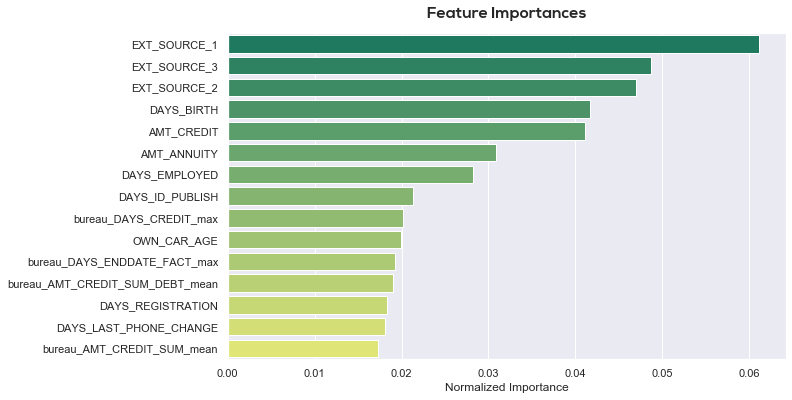

In [23]:
plot_feature_importances(feature_importances)

In [24]:
metrics

fold     train     valid
0     0  0.824471  0.763942
1     1  0.817418  0.764946
2     2  0.835671  0.757278
3     3  0.815857  0.763879
4     4  0.805918  0.764587
5  mean  0.819867  0.762926

In [25]:
train_sample = train.iloc[:1000,:]
test_sample = test.iloc[:1000,:]

In [26]:
pred_sample, fi_sample, metrics_sample = run_LGBM(train_sample,test_sample)

Before encoding :

Training shape:  (1000, 200)
Testing shape:  (1000, 200)

After encoding :

Training shape:  (1000, 303)
Testing shape:  (1000, 303)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	train's auc: 1	train's binary_logloss: 0.206862	valid's auc: 0.798759	valid's binary_logloss: 0.320155
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[22]	train's auc: 0.998824	train's binary_logloss: 0.314618	valid's auc: 0.760369	valid's binary_logloss: 0.406905
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 1	train's binary_logloss: 0.00638762	valid's auc: 0.824505	valid's binary_logloss: 0.244102
Early stopping, best iteration is:
[119]	train's auc: 1	train's binary_logloss: 0.0240445	valid's auc: 0.824144	valid's binary_logloss: 0.226318
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	train's au

In [27]:
metrics_sample

fold     train     valid
0     0  1.000000  0.798759
1     1  0.998824  0.760369
2     2  1.000000  0.824144
3     3  1.000000  0.584944
4     4  1.000000  0.763587
5  mean  0.999765  0.746361

In [28]:
np.shape(probas)

(5, 1000, 2)

In [29]:
probas

[array([[0.87279713, 0.12720287],
        [0.67728266, 0.32271734],
        [0.80063314, 0.19936686],
        ...,
        [0.20910716, 0.79089284],
        [0.1523608 , 0.8476392 ],
        [0.85796551, 0.14203449]]),
 array([[0.80962311, 0.19037689],
        [0.68237714, 0.31762286],
        [0.7948167 , 0.2051833 ],
        ...,
        [0.24761647, 0.75238353],
        [0.20676623, 0.79323377],
        [0.79566592, 0.20433408]]),
 array([[0.99512898, 0.00487102],
        [0.9614135 , 0.0385865 ],
        [0.99637787, 0.00362213],
        ...,
        [0.61289225, 0.38710775],
        [0.36581585, 0.63418415],
        [0.94606126, 0.05393874]]),
 array([[0.97489947, 0.02510053],
        [0.96890454, 0.03109546],
        [0.98405935, 0.01594065],
        ...,
        [0.44263597, 0.55736403],
        [0.09174678, 0.90825322],
        [0.88430771, 0.11569229]]),
 array([[0.81066286, 0.18933714],
        [0.76953288, 0.23046712],
        [0.94638367, 0.05361633],
        ...,
        [

In [30]:
pred_sample

SK_ID_CURR    TARGET
0        100001  0.107378
1        100005  0.188098
2        100013  0.095546
3        100028  0.175770
4        100038  0.331741
..          ...       ...
995      106851  0.083689
996      106852  0.098678
997      106853  0.675182
998      106854  0.784317
999      106861  0.127339

[1000 rows x 2 columns]

In [31]:
train_sample = train.iloc[:10000,:]
test_sample = test.iloc[:1000,:]

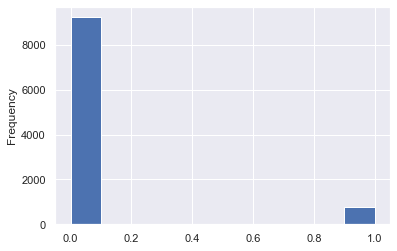

In [32]:
train_sample['TARGET'].astype(int).plot.hist();

In [33]:
pred_sample, fi_sample, metrics_sample = run_LGBM(train_sample,test_sample)

Before encoding :

Training shape:  (10000, 200)
Testing shape:  (1000, 200)

After encoding :

Training shape:  (10000, 304)
Testing shape:  (1000, 304)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.921682	train's binary_logloss: 0.486151	valid's auc: 0.76646	valid's binary_logloss: 0.524728
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	train's auc: 0.961925	train's binary_logloss: 0.372278	valid's auc: 0.711158	valid's binary_logloss: 0.460924
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.948165	train's binary_logloss: 0.411	valid's auc: 0.749261	valid's binary_logloss: 0.468745
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	train's auc: 0.977851	train's binary_logloss: 0.321135	valid's auc: 0.739078	valid's binary_logloss: 0.414831
T

In [34]:
pred_sample

SK_ID_CURR    TARGET
0        100001  0.225650
1        100005  0.398163
2        100013  0.167372
3        100028  0.272691
4        100038  0.641004
..          ...       ...
995      106851  0.345513
996      106852  0.205216
997      106853  0.584812
998      106854  0.801483
999      106861  0.172377

[1000 rows x 2 columns]

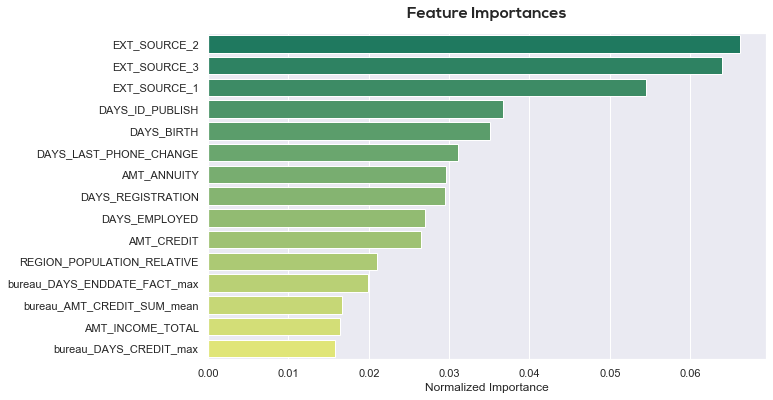

In [35]:
plot_feature_importances(fi_sample)

In [36]:
metrics_sample

fold     train     valid
0     0  0.921682  0.766460
1     1  0.961925  0.711158
2     2  0.948165  0.749261
3     3  0.977851  0.739078
4     4  0.975318  0.740170
5  mean  0.956988  0.741225

In [37]:
train_sample = train.iloc[:10000,:]
test_sample = test.iloc[:1000,:]

In [49]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, resample='SMOTE')

Positive weight : None

Before cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

There are 0 columns with greater than 90% missing values.
After cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

After encoding :
Training shape:  (10000, 271)
Testing shape:  (100, 271)

Resampling model : SMOTE
After separating and resampling data:
Training shape:  (12950, 271)
Validating shape:  (3000, 271)
Testing shape:  (100, 271)

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.999785	train's binary_logloss: 0.0564461	valid's auc: 0.738785	valid's binary_logloss: 0.26134
Early stopping, best iteration is:
[122]	train's auc: 0.997728	train's binary_logloss: 0.0925235	valid's auc: 0.750617	valid's binary_logloss: 0.255617

Done in 0min 11.6s


In [50]:
scores_df

Valid Accuracy  Log_loss    AUC
LGBM           0.917     0.256  0.515

In [51]:
valid_pred

[array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]

In [52]:
valid_proba

[array([0.06750305, 0.01384607, 0.03825065, ..., 0.04394364, 0.01665417,
        0.22972535])]

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2750
           1       0.53      0.03      0.06       250

    accuracy                           0.92      3000
   macro avg       0.73      0.51      0.51      3000
weighted avg       0.89      0.92      0.88      3000



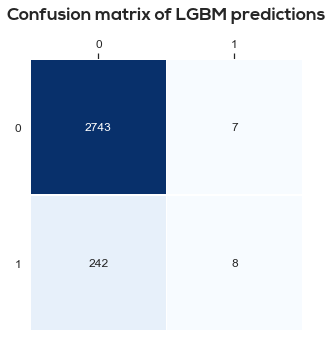

In [53]:
target_names = ['0','1']

model_ID = 0

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

### XGBOOST 

In [43]:
train_sample = train.iloc[:10000,:]
test_sample = test.iloc[:100,:]

Before encoding :

Training shape:  (10000, 200)
Testing shape:  (100, 200)

After encoding :

Training shape:  (10000, 271)
Testing shape:  (100, 271)

[0]	eval-auc:0.66728	train-auc:0.64434
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 100 rounds.
[1]	eval-auc:0.72548	train-auc:0.69823
[2]	eval-auc:0.73160	train-auc:0.72848
[3]	eval-auc:0.75284	train-auc:0.74441
[4]	eval-auc:0.75498	train-auc:0.75980
[5]	eval-auc:0.76099	train-auc:0.77121
[6]	eval-auc:0.76550	train-auc:0.78109
[7]	eval-auc:0.76148	train-auc:0.79028
[8]	eval-auc:0.76537	train-auc:0.79537
[9]	eval-auc:0.76763	train-auc:0.79970
[0]	eval-auc:0.65062	train-auc:0.67935
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 100 rounds.
[1]	eval-auc:0.67636	train-auc:0.72090
[2]	eval-auc:0.68179	train-auc:0.72796
[3]	eval-auc:0.69388	train-auc:0.75468
[4]	eval-auc:

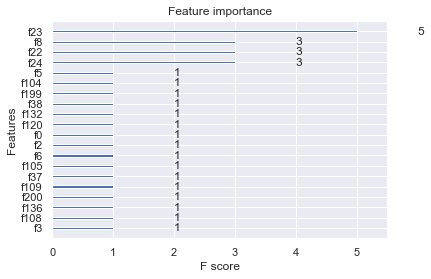

In [44]:
submission, metrics = run_XGBOOST(train_sample, test_sample)

In [45]:
submission

SK_ID_CURR    TARGET
0       100001  0.022779
1       100005  0.065552
2       100013  0.018243
3       100028  0.035585
4       100038  0.248899
..         ...       ...
95      100752  0.030487
96      100753  0.368599
97      100754  0.217458
98      100760  0.020734
99      100762  0.039078

[100 rows x 2 columns]

In [46]:
metrics

fold     valid
0        0  0.799703
1        1  0.806199
2        2  0.801049
3        3  0.798099
4        4  0.805021
5  overall  0.732214

In [55]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, resample='SMOTE')

Positive weight : None

Before cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

There are 0 columns with greater than 90% missing values.
After cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

After encoding :
Training shape:  (10000, 271)
Testing shape:  (100, 271)

Resampling model : SMOTE
After separating and resampling data:
Training shape:  (12950, 271)
Validating shape:  (3000, 271)
Testing shape:  (100, 271)


Done in 0min 12.7s


In [56]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost           0.823     0.504  0.598

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      2750
           1       0.18      0.33      0.24       250

    accuracy                           0.82      3000
   macro avg       0.56      0.60      0.57      3000
weighted avg       0.87      0.82      0.84      3000



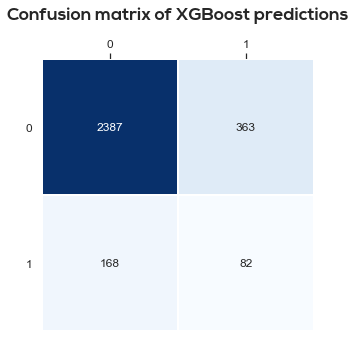

In [57]:
target_names = ['0','1']

model_ID = 0

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [58]:
valid_proba[:50]

[array([0.3763171 , 0.23235081, 0.31744853, ..., 0.2965395 , 0.26280528,
        0.40024027], dtype=float32)]

In [59]:
valid_pred[:100]

[array([0, 0, 0, ..., 0, 0, 0], dtype=int64)]

### Benchmark de classifiers

#### Tests différents classifiers

In [44]:
train_sample = train.iloc[:1000,:]
test_sample = test.iloc[:100,:]
target_names = ['0','1']

In [45]:
scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample)#, resample='SMOTE')

Positive weight : 13.0

Before cleaning NaNs :
Training shape:  (1000, 200)
Testing shape:  (100, 200)

There are 0 columns with greater than 90% missing values.
After cleaning NaNs :
Training shape:  (1000, 200)
Testing shape:  (100, 200)

After encoding :
Training shape:  (1000, 271)
Testing shape:  (100, 271)

Resampling model : None
After separating data:
Training shape:  (700, 271)
Validating shape:  (300, 271)
Testing shape:  (100, 271)


Done in 0min 41.0s


In [46]:
scores_df

Valid Accuracy  Log_loss    AUC
KNN                        0.930     1.399  0.500
Linear SVM                 0.910     0.244  0.533
RBF SVM                    0.930     0.254  0.500
Gaussian Process           0.883     0.693  0.541
Decision Tree              0.930     0.227  0.500
Random Forest              0.930     0.254  0.500
Neural Net                 0.910     0.300  0.511
AdaBoost                   0.920     0.578  0.605
Naive Bayes                0.317    23.602  0.567
QDA                        0.903     3.339  0.508

In [47]:
np.shape(test_pred),np.shape(test_proba)

((10, 100), (10, 100))

In [33]:
# LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, feature_names=feature_names, class_names=[0,1], discretize_continuous=True)

In [57]:
model = 'Random Forest'
client_ID = 0

exp = explainer.explain_instance(X_valid[client_ID], models[model].predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

In [32]:
scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, resample='SMOTE')

Positive weight : None

Before cleaning NaNs :
Training shape:  (1000, 200)
Testing shape:  (100, 200)

There are 0 columns with greater than 90% missing values.
After cleaning NaNs :
Training shape:  (1000, 200)
Testing shape:  (100, 200)

After encoding :
Training shape:  (1000, 271)
Testing shape:  (100, 271)

Resampling model : SMOTE
After separating and resampling data:
Training shape:  (1302, 271)
Validating shape:  (300, 271)
Testing shape:  (100, 271)


Done in 2min 30.5s


In [35]:
scores_df

Valid Accuracy  Log_loss    AUC
KNN                        0.557     7.863  0.541
Linear SVM                 0.823     0.534  0.531
RBF SVM                    0.930     0.342  0.500
Gaussian Process           0.853     0.426  0.547
Decision Tree              0.710     0.488  0.448
Random Forest              0.630     0.657  0.537
Neural Net                 0.867     0.413  0.532
AdaBoost                   0.860     0.606  0.528
Naive Bayes                0.317    23.482  0.545
QDA                        0.920     2.763  0.517

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       279
           1       0.00      0.00      0.00        21

    accuracy                           0.93       300
   macro avg       0.47      0.50      0.48       300
weighted avg       0.86      0.93      0.90       300



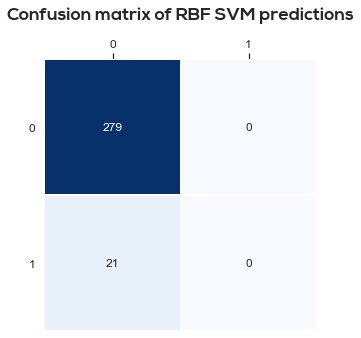

In [53]:
model = 'RBF SVM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [55]:
p = 50

print("Model :", scores_df.index[model_ID][0])
print('Score:', scores_df['Valid Accuracy'][model_ID])
print()
print(y_valid.values[:p])
print()
print(valid_pred[model_ID][:p])
print(valid_proba[model_ID][:p])
print()
print(test_pred[model_ID][:p])
print(test_proba[model_ID][:p])

Model : RBF SVM
Score: 0.93

[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.06604625 0.06604625 0.06604625 0.06604625 0.06604625 0.06604625
 0.06604625 0.06604625 0.06604625

#### Tests LBGM / XGBoost / CatBoost

##### bureau / bureau_balance

In [61]:
train_sample = train.iloc[:10000,:]
test_sample = test.iloc[:100,:]
target_names = ['0','1']

The selected dataframe has 202 columns.
There are 148 columns that have missing values.


[]

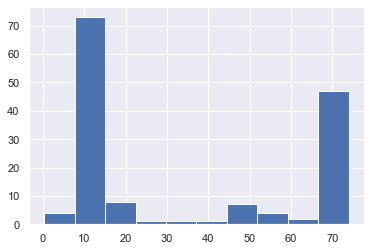

In [62]:
df = missing_values_table(train_sample)
df['% of Total Values'].hist().plot()

In [63]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, NaN_thresh=30) #, resample='RUS')

Positive weight : 12.0

Before cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

There are 62 columns with greater than 30% missing values.
After cleaning NaNs :
Training shape:  (10000, 138)
Testing shape:  (100, 138)

After encoding :
Training shape:  (10000, 191)
Testing shape:  (100, 191)

Resampling model : None
After separating data:
Training shape:  (7000, 191)
Validating shape:  (3000, 191)
Testing shape:  (100, 191)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.742622	train's binary_logloss: 0.679426	valid's auc: 0.679959	valid's binary_logloss: 0.70706

Done in 0min 6.3s


In [64]:
predictions

SK_ID_CURR  XGBoost  XGBoost (proba)  LGBM  LGBM (proba)
0       100001        0         0.362269     0      0.475185
1       100005        0         0.294552     0      0.475185
2       100013        0         0.302795     0      0.475185
3       100028        0         0.317017     0      0.475185
4       100038        0         0.290062     0      0.475185
..         ...      ...              ...   ...           ...
95      100752        0         0.317738     0      0.475185
96      100753        0         0.406003     0      0.475185
97      100754        0         0.400720     0      0.475185
98      100760        0         0.290062     0      0.475185
99      100762        0         0.283303     0      0.475185

[100 rows x 5 columns]

In [65]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost           0.712     0.593  0.655
LGBM              0.333     0.707  0.580

              precision    recall  f1-score   support

           0       0.95      0.72      0.82      2750
           1       0.16      0.59      0.25       250

    accuracy                           0.71      3000
   macro avg       0.56      0.66      0.54      3000
weighted avg       0.88      0.71      0.77      3000



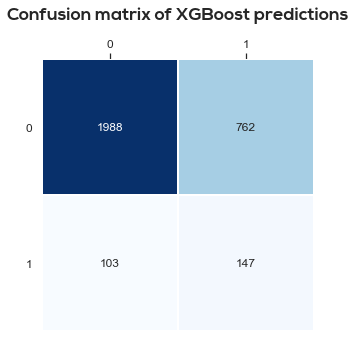

In [66]:
model_ID = 0

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.28      0.44      2750
           1       0.10      0.88      0.18       250

    accuracy                           0.33      3000
   macro avg       0.53      0.58      0.31      3000
weighted avg       0.89      0.33      0.42      3000



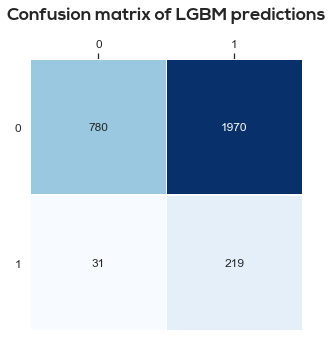

In [67]:
model_ID = 1

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [81]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, resample='RUS', NaN_thresh=30)

Positive weight : None

Before cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

There are 62 columns with greater than 30% missing values.
After cleaning NaNs :
Training shape:  (10000, 138)
Testing shape:  (100, 138)

After encoding :
Training shape:  (10000, 191)
Testing shape:  (100, 191)

Resampling model : RUS
After separating and resampling data:
Training shape:  (1050, 191)
Validating shape:  (3000, 191)
Testing shape:  (100, 191)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.965979	train's binary_logloss: 0.42009	valid's auc: 0.72194	valid's binary_logloss: 0.633929

Done in 0min 2.7s


In [82]:
predictions

SK_ID_CURR  XGBoost  XGBoost (proba)  LGBM  LGBM (proba)
0       100001        0         0.329598     0      0.279345
1       100005        0         0.358517     0      0.256219
2       100013        0         0.345674     0      0.256455
3       100028        0         0.360472     0      0.255492
4       100038        0         0.345713     0      0.244585
..         ...      ...              ...   ...           ...
95      100752        0         0.364064     0      0.231885
96      100753        0         0.373488     0      0.302378
97      100754        0         0.348176     0      0.343978
98      100760        0         0.360472     0      0.231885
99      100762        0         0.327772     0      0.250603

[100 rows x 5 columns]

In [83]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost           0.676     0.632  0.667
LGBM              0.656     0.634  0.663

              precision    recall  f1-score   support

           0       0.96      0.68      0.79      2750
           1       0.16      0.66      0.25       250

    accuracy                           0.68      3000
   macro avg       0.56      0.67      0.52      3000
weighted avg       0.89      0.68      0.75      3000



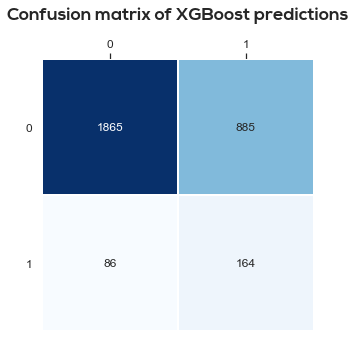

In [84]:
model_ID = 0

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [85]:
i = 1
a = -( y_valid.values[i] * np.log10(valid_proba[model_ID][i]) + \
                 (1 - y_valid.values[i]) * np.log10(1 - valid_proba[model_ID][i]) )
a

0.22690434448103244

In [86]:
from sklearn import metrics
precision = metrics.precision_score(y_valid, valid_pred[model_ID])
recall = metrics.recall_score(y_valid, valid_pred[model_ID])
f1 = metrics.f1_score(y_valid, valid_pred[model_ID])
f2 = 5 * (precision * recall) / (4 * precision + recall)

logloss = []
for i in range(len(y_valid)):
    logloss.append( -( y_valid.values[i] * np.log10(valid_proba[model_ID][i]) + \
                 (1 - y_valid.values[i]) * np.log10(1 - valid_proba[model_ID][i]) ))
    
print('Precision :', precision)
print('Recall :', recall)
print('F1 score :', f1)
print('F2 score :', f2)
print('Log loss :', np.mean(logloss))

Precision : 0.1563393708293613
Recall : 0.656
F1 score : 0.2525019245573518
F2 score : 0.4001952171791118
Log loss : 0.27445452934930925


              precision    recall  f1-score   support

           0       0.96      0.65      0.78      2750
           1       0.15      0.67      0.25       250

    accuracy                           0.66      3000
   macro avg       0.55      0.66      0.51      3000
weighted avg       0.89      0.66      0.73      3000



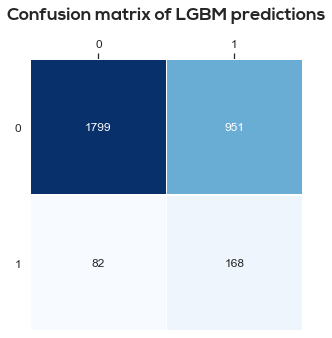

In [74]:
model_ID = 1

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [75]:
from sklearn import metrics
precision = metrics.precision_score(y_valid, valid_pred[model_ID])
recall = metrics.recall_score(y_valid, valid_pred[model_ID])
f1 = metrics.f1_score(y_valid, valid_pred[model_ID])
f2 = 5 * (precision * recall) / (4 * precision + recall)
print('Precision :', precision)
print('Recall', recall)
print('F1 score', f1)
print('F2 score', f2)

Precision : 0.15013404825737264
Recall 0.672
F1 score 0.24543462381300218
F2 score 0.3964134025483718


In [76]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, resample='SMOTE', NaN_thresh=30)

Positive weight : None

Before cleaning NaNs :
Training shape:  (10000, 200)
Testing shape:  (100, 200)

There are 62 columns with greater than 30% missing values.
After cleaning NaNs :
Training shape:  (10000, 138)
Testing shape:  (100, 138)

After encoding :
Training shape:  (10000, 191)
Testing shape:  (100, 191)

Resampling model : SMOTE
After separating and resampling data:
Training shape:  (12950, 191)
Validating shape:  (3000, 191)
Testing shape:  (100, 191)

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.999699	train's binary_logloss: 0.0607997	valid's auc: 0.712623	valid's binary_logloss: 0.266965
Early stopping, best iteration is:
[112]	train's auc: 0.996543	train's binary_logloss: 0.104252	valid's auc: 0.736013	valid's binary_logloss: 0.259716

Done in 0min 14.7s


In [77]:
predictions

SK_ID_CURR  XGBoost  XGBoost (proba)  LGBM  LGBM (proba)
0       100001        1         0.699827     1      0.947334
1       100005        1         0.715202     1      0.931713
2       100013        1         0.755136     1      0.904418
3       100028        1         0.689664     1      0.771868
4       100038        1         0.700576     1      0.864095
..         ...      ...              ...   ...           ...
95      100752        1         0.747078     1      0.930594
96      100753        1         0.698046     1      0.953599
97      100754        1         0.697620     1      0.952096
98      100760        1         0.746330     1      0.901701
99      100762        1         0.690796     1      0.950809

[100 rows x 5 columns]

In [78]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost           0.802     0.515  0.605
LGBM              0.917     0.260  0.516

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      2750
           1       0.17      0.37      0.24       250

    accuracy                           0.80      3000
   macro avg       0.56      0.60      0.56      3000
weighted avg       0.87      0.80      0.83      3000



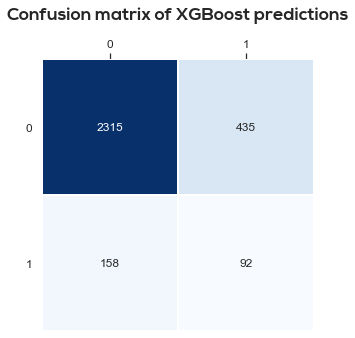

In [79]:
model_ID = 0

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2750
           1       0.50      0.04      0.07       250

    accuracy                           0.92      3000
   macro avg       0.71      0.52      0.51      3000
weighted avg       0.88      0.92      0.88      3000



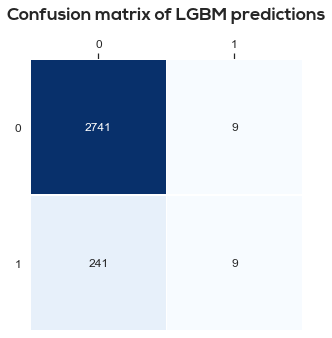

In [80]:
model_ID = 1

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

##### Avec toutes les variables réunies

In [12]:
# First 10000 rows
# train = pd.read_csv('Fichiers/train_all_merged_corrs_removed_first_10000.csv')
# test = pd.read_csv('Fichiers/test_all_merged_corrs_removed.csv')

In [5]:
# Random 50000 rows
train = pd.read_csv('Fichiers/train_all_merged_mean_corrs_removed_random_50000.csv')
test = pd.read_csv('Fichiers/test_all_merged_mean_corrs_removed.csv')

In [6]:
print('Training Shape: ', train.shape)
print('Testing Shape: ', test.shape)

Training Shape:  (50000, 482)
Testing Shape:  (48744, 481)


In [7]:
train_sample = train.iloc[:50000,:]
test_sample = test.iloc[:100,:]
target_names = ['0','1']

In [8]:
# Convert TARGET boolean into integers (cf. how data was built) 
train_sample['TARGET'] = train_sample['TARGET'].astype(int)
train_sample['TARGET'].unique()

array([0, 1])

In [22]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, NaN_thresh=20) #, resample='RUS')

Positive weight : 11.0

Before cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (100, 480)

There are 3 columns with greater than 20% missing values.
After cleaning NaNs :
Training shape:  (50000, 477)
Testing shape:  (100, 477)

After encoding :
Training shape:  (50000, 530)
Testing shape:  (100, 530)

Resampling model : None
After separating data:
Training shape:  (35000, 530)
Validating shape:  (15000, 530)
Testing shape:  (100, 530)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid's binary_logloss: 0.283133
0:	learn: 0.6831671	test: 0.6831508	best: 0.6831508 (0)	total: 75.6ms	remaining: 680ms
1:	learn: 0.6741438	test: 0.6735363	best: 0.6735363 (1)	total: 184ms	remaining: 735ms
2:	learn: 0.6674042	test: 0.6663819	best: 0.6663819 (2)	total: 278ms	remaining: 648ms
3:	learn: 0.6621486	test: 0.6609700	best: 0.6609700 (3)	total: 369ms	remaining: 553ms
4:	learn: 0.6579590	test: 0.6567268	best: 0.6567268 (4)	total: 455

In [108]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.680     0.621  0.668
LGBM               0.702     6.650  0.687
CatBoost           0.672     0.637  0.667

In [11]:
# fonctions existantes - early 1000
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.680     0.621  0.668
LGBM               0.893     0.328  0.583
CatBoost           0.672     0.637  0.667

In [15]:
# fonctions existantes - early 100
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.680     0.621  0.668
LGBM               0.188     0.719  0.545
CatBoost           0.672     0.637  0.667

In [23]:
# fonctions existantes - early 200
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.680     0.621  0.668
LGBM               0.916     0.283  0.500
CatBoost           0.672     0.637  0.667

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     13743
           1       0.16      0.65      0.26      1257

    accuracy                           0.68     15000
   macro avg       0.56      0.67      0.53     15000
weighted avg       0.89      0.68      0.75     15000



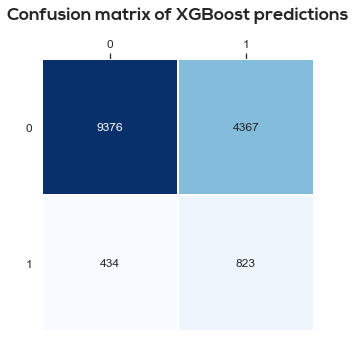

In [109]:
model = 'XGBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.71      0.81     13743
           1       0.17      0.67      0.27      1257

    accuracy                           0.70     15000
   macro avg       0.57      0.69      0.54     15000
weighted avg       0.89      0.70      0.77     15000



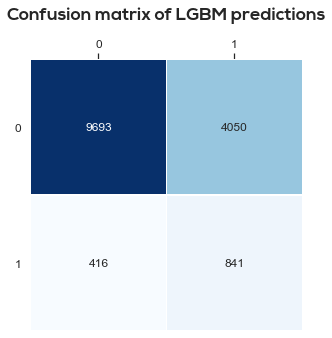

In [110]:
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.93      0.96      0.94     13743
           1       0.30      0.21      0.25      1257

    accuracy                           0.89     15000
   macro avg       0.61      0.58      0.59     15000
weighted avg       0.88      0.89      0.88     15000



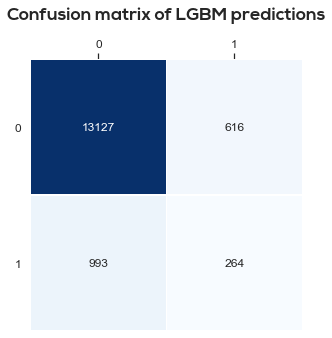

In [12]:
# fonctions existantes - early 1000
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     13743
           1       0.00      0.00      0.00      1257

    accuracy                           0.92     15000
   macro avg       0.46      0.50      0.48     15000
weighted avg       0.84      0.92      0.88     15000



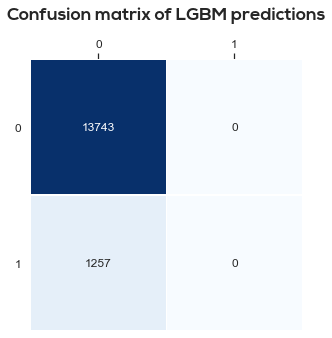

In [24]:
# fonctions existantes - early 1000
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.98      0.12      0.21     13743
           1       0.09      0.97      0.17      1257

    accuracy                           0.19     15000
   macro avg       0.54      0.55      0.19     15000
weighted avg       0.91      0.19      0.20     15000



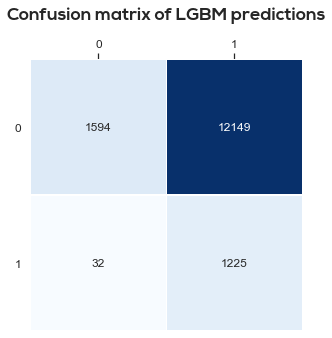

In [16]:
# fonctions existantes - early 100
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     13743
           1       0.16      0.66      0.25      1257

    accuracy                           0.67     15000
   macro avg       0.56      0.67      0.52     15000
weighted avg       0.89      0.67      0.74     15000



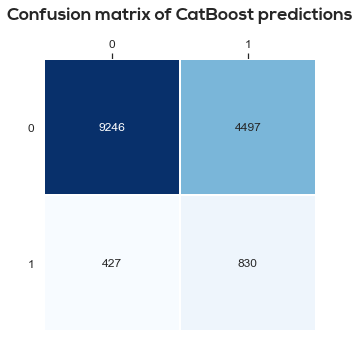

In [111]:
model = 'CatBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [30]:
models['LGBM'].best_score_

defaultdict(collections.OrderedDict,
            {'valid': OrderedDict([('custom logloss', 1.0920088969020632)])})

In [129]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, NaN_thresh=30, resample='RUS')

Positive weight : None

Before cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (100, 480)

There are 0 columns with greater than 30% missing values.
After cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (100, 480)

After encoding :
Training shape:  (50000, 533)
Testing shape:  (100, 533)

Resampling model : RUS
After separating and resampling data:
Training shape:  (5734, 533)
Validating shape:  (15000, 533)
Testing shape:  (100, 533)

Training until validation scores don't improve for 1000 rounds
[200]	valid's binary_logloss: 0.605163
[400]	valid's binary_logloss: 0.626956
[600]	valid's binary_logloss: 0.650554
[800]	valid's binary_logloss: 0.677539
[1000]	valid's binary_logloss: 0.709308
Early stopping, best iteration is:
[104]	valid's binary_logloss: 0.599169
0:	learn: 0.6834747	test: 0.6843494	best: 0.6843494 (0)	total: 18.6ms	remaining: 168ms
1:	learn: 0.6746719	test: 0.6760214	best: 0.6760214 (1)	total: 32.2ms	remaining: 129ms
2:	learn: 0.6684807	test:

In [130]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.673     0.634  0.669
LGBM               0.685     0.599  0.688
CatBoost           0.683     0.644  0.667

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     13743
           1       0.16      0.66      0.25      1257

    accuracy                           0.67     15000
   macro avg       0.56      0.67      0.52     15000
weighted avg       0.89      0.67      0.75     15000



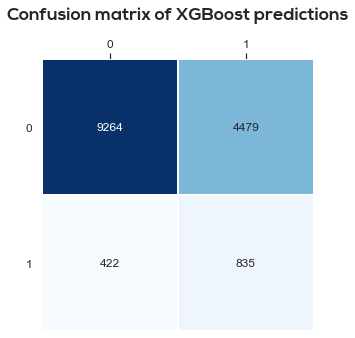

In [131]:
model = 'XGBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     13743
           1       0.17      0.69      0.27      1257

    accuracy                           0.68     15000
   macro avg       0.56      0.69      0.53     15000
weighted avg       0.89      0.68      0.75     15000



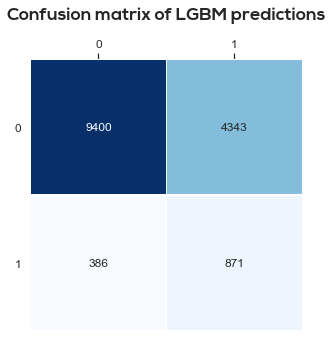

In [132]:
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     13743
           1       0.16      0.65      0.25      1257

    accuracy                           0.68     15000
   macro avg       0.56      0.67      0.53     15000
weighted avg       0.89      0.68      0.75     15000



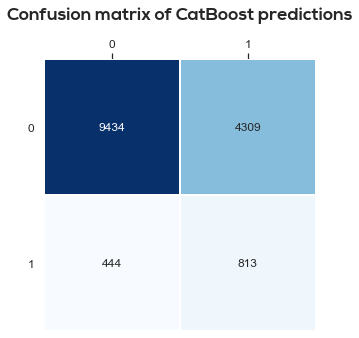

In [133]:
model = 'CatBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

In [177]:
model = 'CatBoost'
model_ID = list(models.keys()).index(model)

print(y_valid[:10].values)
print(valid_pred[model_ID][:10])
print(valid_proba[model_ID][:10])

[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 1 1 0 0]
[0.43737729 0.43698234 0.51615598 0.34502616 0.4597431  0.3944717
 0.52802266 0.5225216  0.37112163 0.39516885]


In [35]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, NaN_thresh=20, resample='SMOTE')

Positive weight : None

Before cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (100, 480)

There are 3 columns with greater than 20% missing values.
After cleaning NaNs :
Training shape:  (50000, 477)
Testing shape:  (100, 477)

After encoding :
Training shape:  (50000, 530)
Testing shape:  (100, 530)

Resampling model : SMOTE
After separating and resampling data:
Training shape:  (64266, 530)
Validating shape:  (15000, 530)
Testing shape:  (100, 530)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[49]	valid's custom logloss: 1.10151

Done in 2min 44.8s


In [36]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost           0.884     0.498  0.536
LGBM              0.894     1.818  0.543

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     13743
           1       0.19      0.12      0.14      1257

    accuracy                           0.88     15000
   macro avg       0.56      0.54      0.54     15000
weighted avg       0.86      0.88      0.87     15000



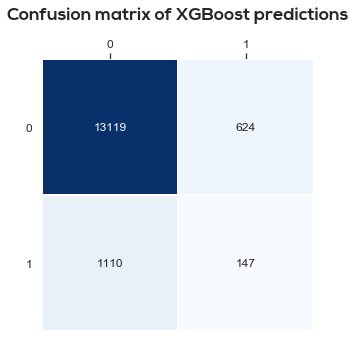

In [37]:
model = 'XGBoost'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     13743
           1       0.24      0.12      0.16      1257

    accuracy                           0.89     15000
   macro avg       0.58      0.54      0.55     15000
weighted avg       0.87      0.89      0.88     15000



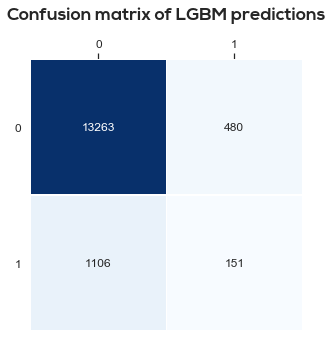

In [38]:
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

## Modèle choisi : LGBM + Random Under Sampling

### Entraînement du modèle

In [22]:
save_path = 'Figures/'

In [23]:
# Random 50000 rows
train = pd.read_csv('Fichiers/train_all_merged_mean_corrs_removed_random_50000.csv')
test = pd.read_csv('Fichiers/test_all_merged_mean_corrs_removed.csv')

In [24]:
print('Training Shape: ', train.shape)
print('Testing Shape: ', test.shape)

Training Shape:  (50000, 482)
Testing Shape:  (48744, 481)


In [25]:
# train_sample = train.iloc[:50000,:]
# test_sample = test.sample(n=10000, random_state=42)

train_sample = train
test_sample = test
target_names = ['0','1']

In [26]:
# Convert TARGET boolean into integers (cf. how data was built) 
train_sample['TARGET'] = train_sample['TARGET'].astype(int)
train_sample['TARGET'].unique()

array([0, 1])

In [27]:
predictions, scores_df, valid_pred, test_pred, valid_proba, test_proba = \
    benchmark_classifiers(train_sample, test_sample, NaN_thresh=30, resample='RUS')

Positive weight : None

Before cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (48744, 480)

There are 0 columns with greater than 30% missing values.
After cleaning NaNs :
Training shape:  (50000, 480)
Testing shape:  (48744, 480)

After encoding :
Training shape:  (50000, 572)
Testing shape:  (48744, 572)

Resampling model : RUS
After separating and resampling data:
Training shape:  (5734, 572)
Validating shape:  (15000, 572)
Testing shape:  (48744, 572)

Training until validation scores don't improve for 1000 rounds
[200]	valid's binary_logloss: 0.608542
[400]	valid's binary_logloss: 0.62933
[600]	valid's binary_logloss: 0.654817
[800]	valid's binary_logloss: 0.682931
[1000]	valid's binary_logloss: 0.711089
Early stopping, best iteration is:
[102]	valid's binary_logloss: 0.599798
0:	learn: 0.6819634	test: 0.6826747	best: 0.6826747 (0)	total: 263ms	remaining: 2.37s
1:	learn: 0.6731821	test: 0.6745801	best: 0.6745801 (1)	total: 292ms	remaining: 1.17s
2:	learn: 0.6665608	

In [28]:
scores_df

Valid Accuracy  Log_loss    AUC
XGBoost            0.673     0.634  0.669
LGBM               0.685     0.600  0.692
CatBoost           0.671     0.642  0.666

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     13743
           1       0.17      0.70      0.27      1257

    accuracy                           0.69     15000
   macro avg       0.56      0.69      0.54     15000
weighted avg       0.89      0.69      0.76     15000



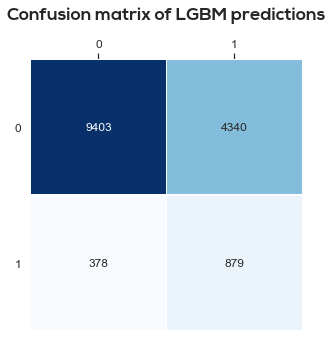

In [29]:
model = 'LGBM'
model_ID = list(models.keys()).index(model)

print(classification_report(y_valid, valid_pred[model_ID], target_names=target_names))
conf_matrix = confusion_matrix(y_valid, valid_pred[model_ID], labels=[0,1])
plot_confusion_matrix(conf_matrix, name=clf_names[model_ID])

### SHAP Values

In [30]:
# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
# X,y = shap.datasets.boston()
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

df_valid = pd.DataFrame(X_valid, columns=feature_names)
model = models['LGBM']

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_valid)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
shap.force_plot(explainer.expected_value[1], shap_values[1][10], df_valid.iloc[10,:])

In [141]:
# visualize the training set predictions
# shap.force_plot(explainer.expected_value[0], shap_values[0], X)

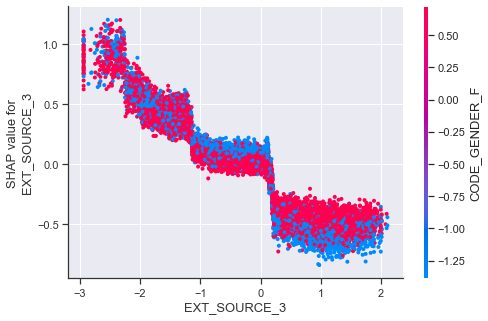

In [200]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("EXT_SOURCE_3", shap_values[1], df_valid)

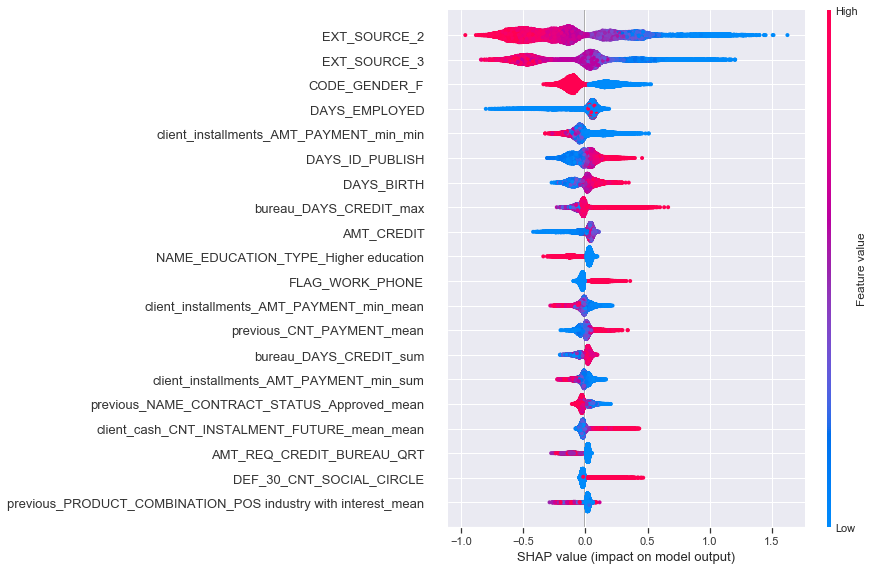

<Figure size 432x288 with 0 Axes>

In [201]:
# summarize the effects of all the features
fig = plt.figure()
shap.summary_plot(shap_values[1], df_valid)
plt.savefig(save_path+'Shap_values_LGBM.png', dpi=200, bbox_inches='tight')
plt.show()

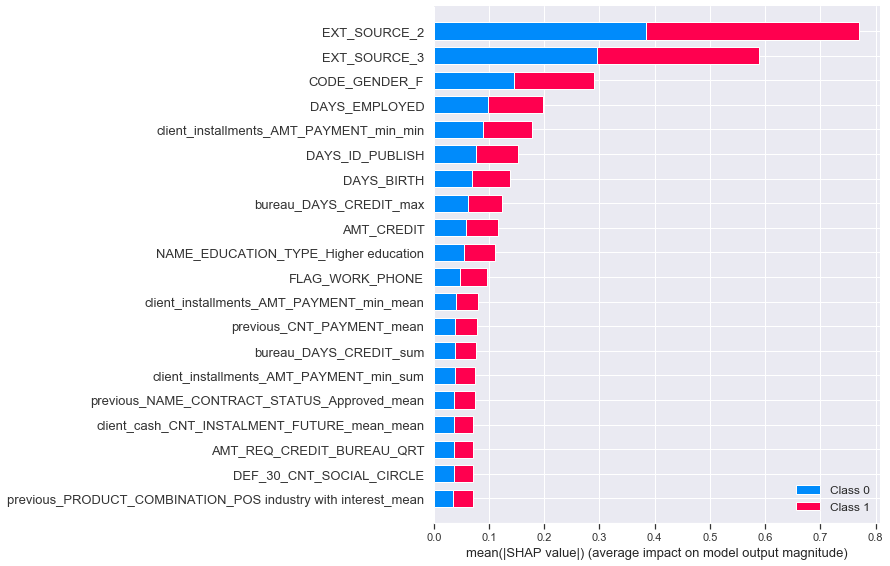

In [202]:
shap.summary_plot(shap_values, df_valid, plot_type="bar")

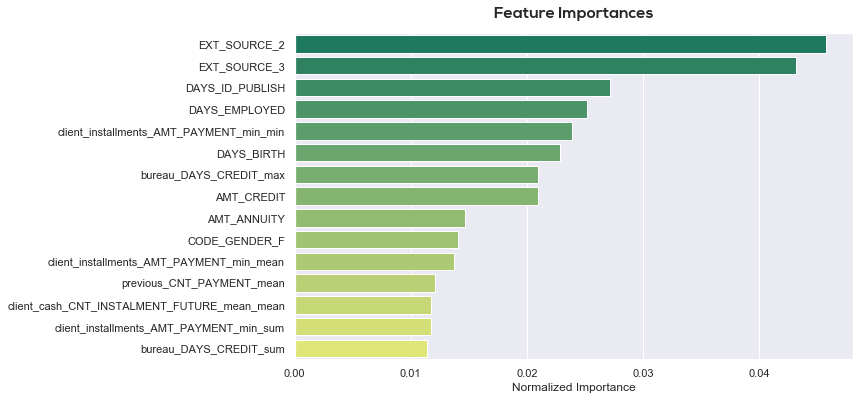

In [203]:
fi = model.feature_importances_
df = pd.DataFrame({'feature': feature_names, 'importance': fi})
df
plot_feature_importances(df)

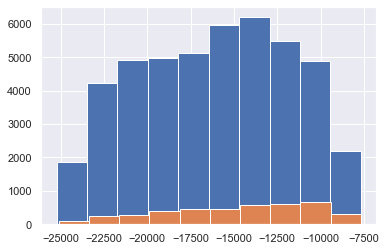

In [204]:
x = train_sample.loc[train_sample['TARGET']==0]
x2 = train_sample.loc[train_sample['TARGET']==1]
plt.hist(x['DAYS_BIRTH'])
plt.hist(x2['DAYS_BIRTH'])

plt.show()

### Clustering des SHAP Values avec KMeans

In [31]:
KMeans_path = 'Figures/KMeans'

# convert shap values array to dataframe
df_shap = pd.DataFrame(shap_values[1], columns=feature_names)

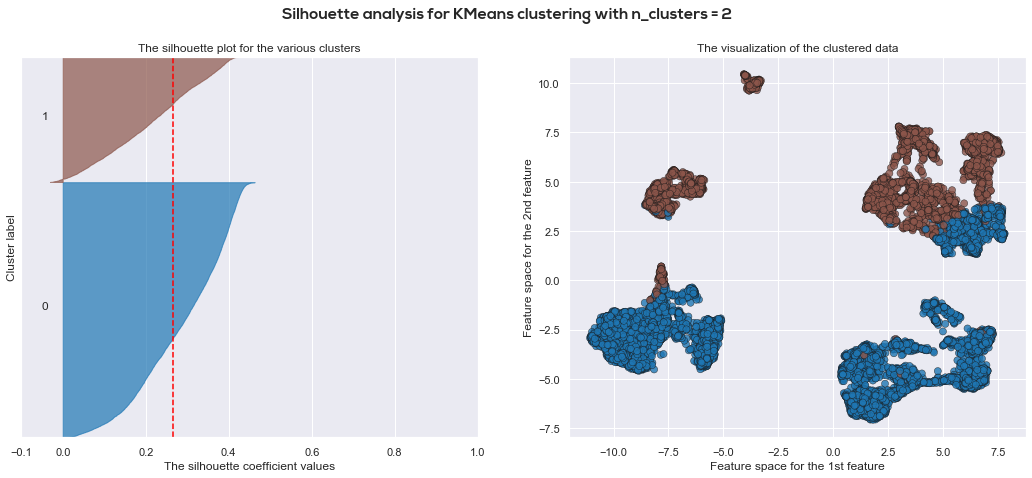

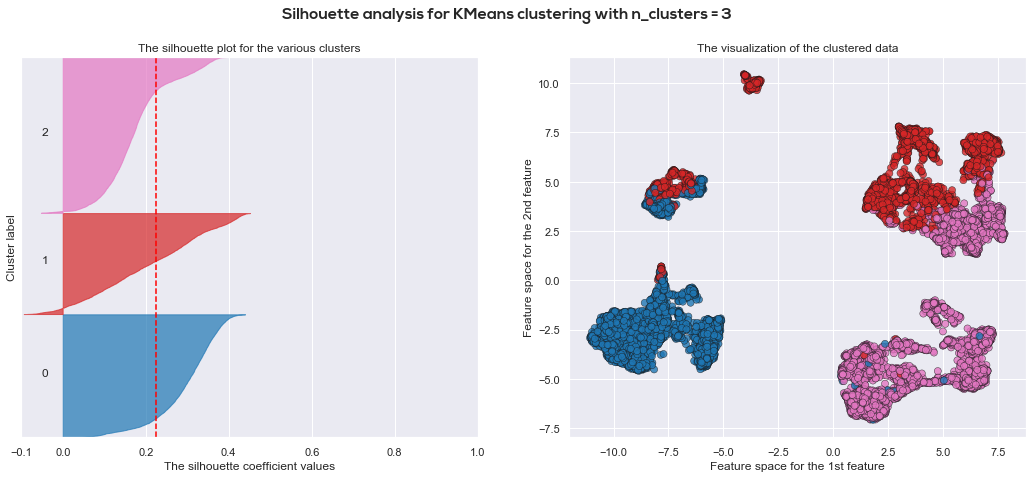

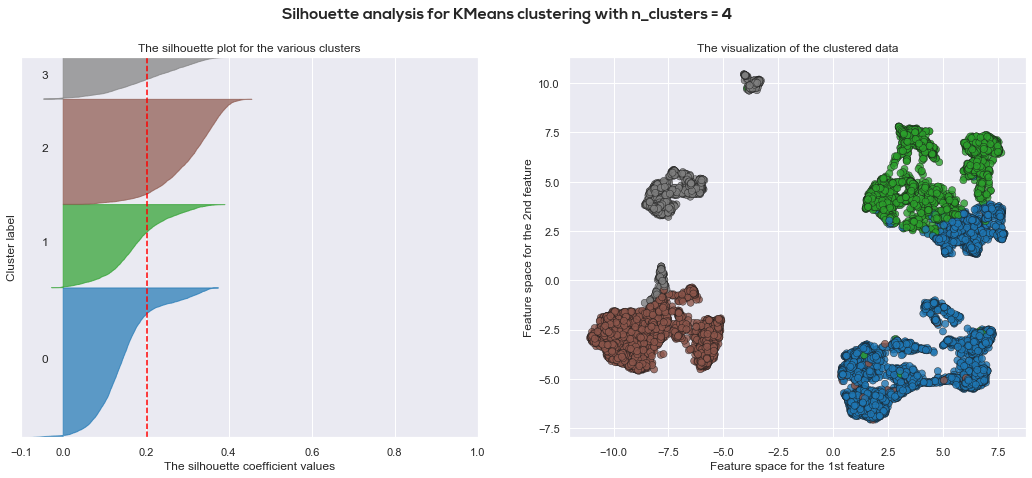

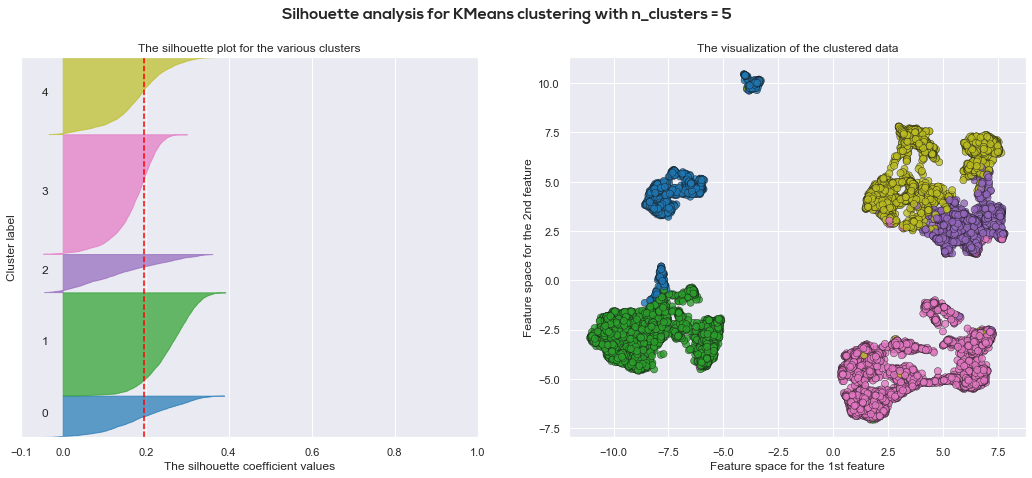

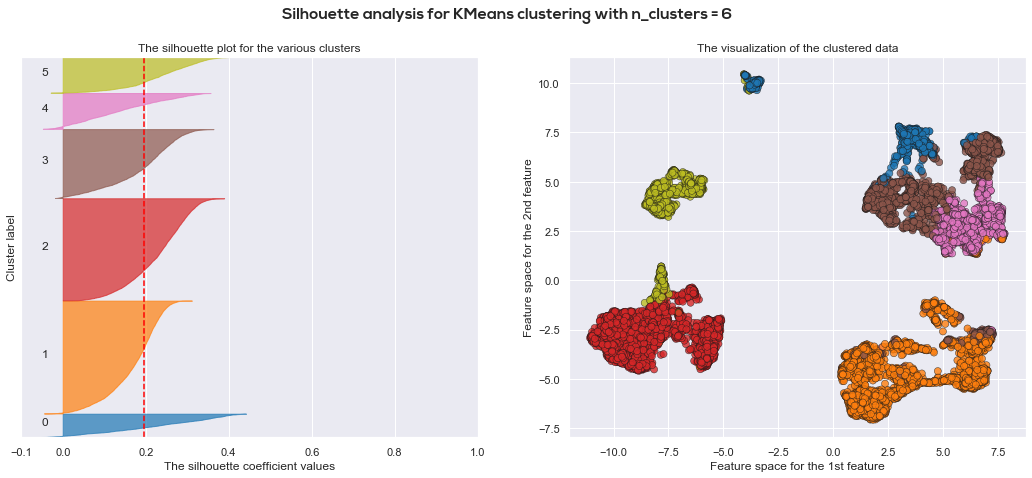

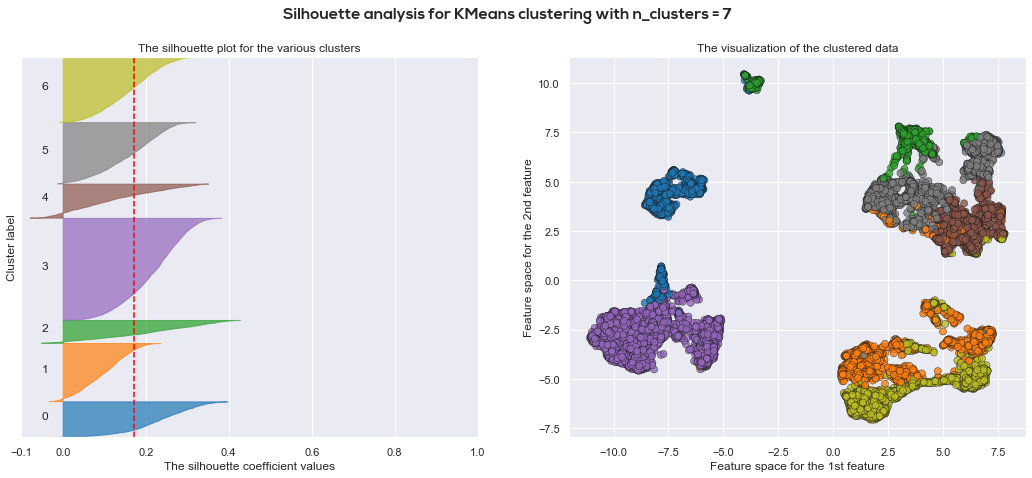

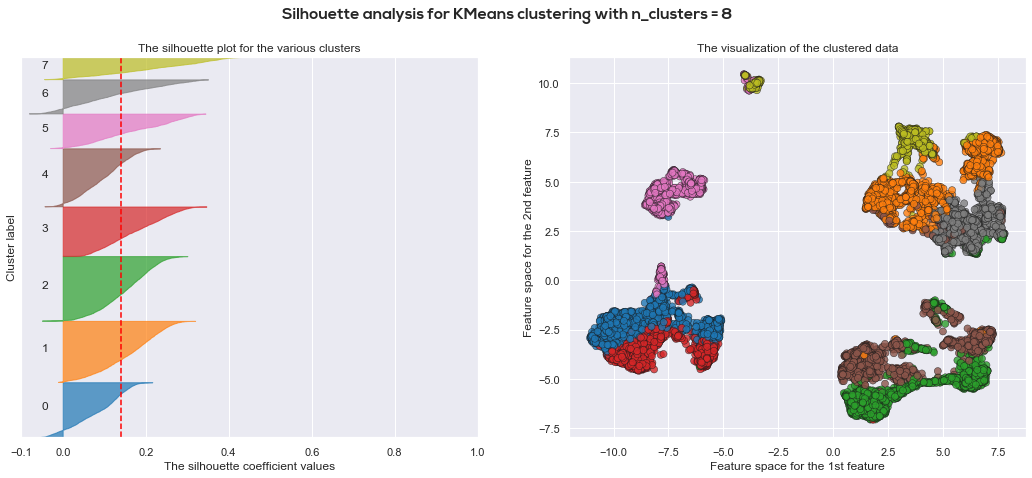

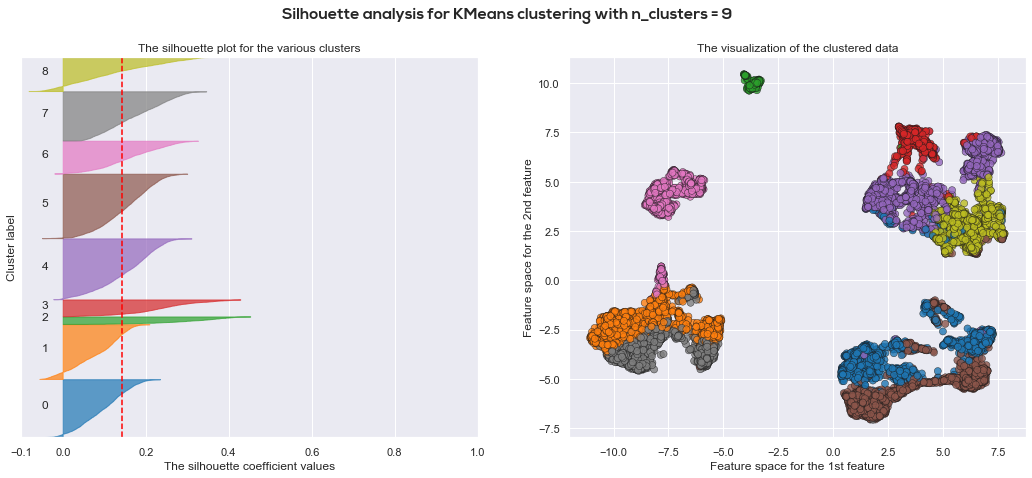

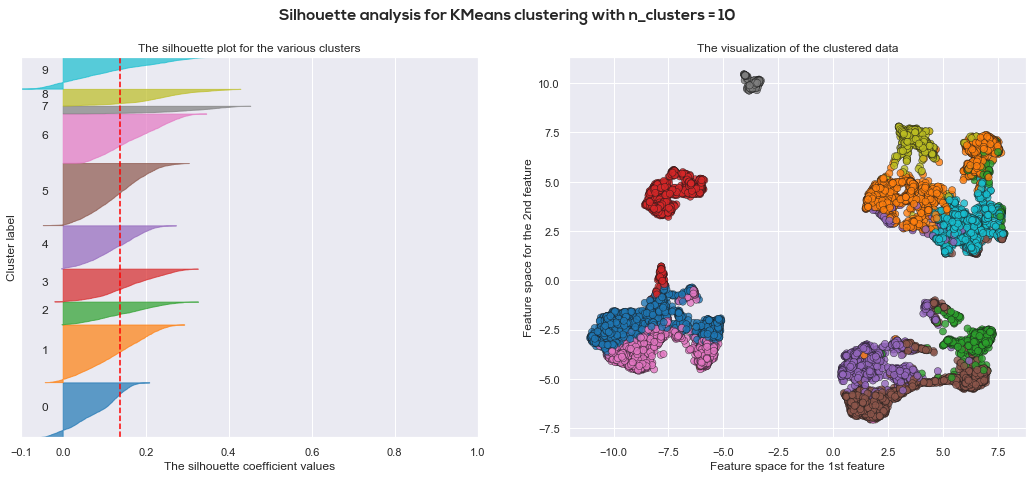


Done in 8min 17.407s


In [180]:
# On appelle notre fonction pour effectuer la boucle KMeans
range_n_clusters = range(2,11)
KMeans_scores = []

KMeans_loop(df_shap, range_n_clusters=range_n_clusters, KMeans_scores=KMeans_scores, 
            save_path=KMeans_path, proj='UMAP')

In [181]:
# convert scores into dataframe
KMeans_scores_df = pd.DataFrame(np.round(KMeans_scores,3), 
                                columns=['Silhouette','Davies-Bouldin',
                                         'Calinski-Harabasz','Inertia'], 
                                index=range_n_clusters)
KMeans_scores_df

Silhouette  Davies-Bouldin  Calinski-Harabasz   Inertia
2        0.266           1.494           5689.802  5531.652
3        0.225           1.429           5395.790  4437.239
4        0.204           1.506           4492.137  4018.714
5        0.196           1.672           4007.356  3687.896
6        0.197           1.552           3716.224  3407.499
7        0.173           1.804           3360.314  3254.159
8        0.141           2.006           3052.063  3146.401
9        0.142           1.924           2809.874  3052.691
10       0.139           1.867           2619.997  2965.433

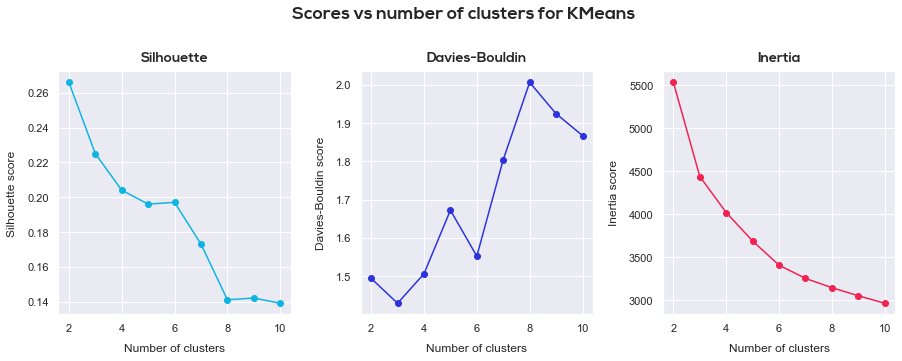

In [182]:
# Graph : scores vs number of clusters
fig = plt.figure(figsize=(15,5))

# Plot
ax = plt.subplot(131)
plt.plot(range_n_clusters, KMeans_scores_df['Silhouette'], '-o', color='#0fb5e2')

ax2 = plt.subplot(132)
plt.plot(range_n_clusters, KMeans_scores_df['Davies-Bouldin'], '-o', color='#2b33df')

ax3 = plt.subplot(133)
plt.plot(range_n_clusters, KMeans_scores_df['Inertia'], '-o', color='#f02352')

# Ajout d'éléments et sauvegarde
ax.set_xlabel('Number of clusters', fontsize=12, labelpad=10)
ax.set_ylabel('Silhouette score', fontsize=12, labelpad=10)
ax.set_title('Silhouette', fontsize=14, pad=10, **csfont)
ax2.set_xlabel('Number of clusters', fontsize=12, labelpad=10)
ax2.set_ylabel('Davies-Bouldin score', fontsize=12, labelpad=10)
ax2.set_title('Davies-Bouldin', fontsize=14, pad=10, **csfont)
ax3.set_xlabel('Number of clusters', fontsize=12, labelpad=10)
ax3.set_ylabel('Inertia score', fontsize=12, labelpad=10)
ax3.set_title('Inertia', fontsize=14, pad=10, **csfont)

plt.subplots_adjust(wspace=0.3, top=0.8)
plt.suptitle('Scores vs number of clusters for KMeans', fontsize=18, **csfont)
plt.savefig(KMeans_path+'/KMeans_Silhouette_DB_inertia.png', dpi=200, bbox_inches='tight')
plt.show()

Avec les scores et les projections 2D (UMAP) que l'on voit, on a plutôt envie de prendre K = 3 ou 6.  

Avec le nombre de données et de clients que l'on a ceci dit, on va choisir 6 clusters plutôt que 3 pour mieux les départager.

### Construction des données clients

In [32]:
# KMeans with k = 6
kmeans = KMeans(n_clusters=6, random_state=42).fit(df_shap)

# selecting cluster centroids
centroids = kmeans.cluster_centers_

In [33]:
clients = df_valid
clients['label'] = kmeans.labels_

model = 'LGBM'
model_ID = list(models.keys()).index(model)

clients['proba'] = valid_proba[model_ID]

clients.index = y_valid.index
clients['TARGET'] = y_valid
clients.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
33553      2.199676         -0.604827   -1.149637    -1.064719   
9427      -0.583808         -0.430990    1.313635     1.425608   
199       -0.583808         -0.604827    0.121839     0.800390   
12447      2.199676          1.655059    0.052883     0.324964   
39489     -0.583808          0.090523   -1.037136    -1.239011   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
33553                   -0.913931   -0.090755      -0.457650   
9427                     0.564633    0.551588      -0.490727   
199                      0.400300    1.434610      -0.462631   
12447                   -0.462829    0.306330      -0.489403   
39489                   -0.662619   -0.917214       2.132252   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
33553          -0.926552         1.970874         0.0        0.468966   
9427            0.694603        -0.334601         0.0        0.468966   
199             0.263917         1.861058         0.0        0.468966   
12447           1.297902        -1.517439         0.0        0.468966   
39489           0.414742        -0.351140         0.0       -2.132352   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
33553        -0.497436          0.038238   -0.621259   -0.247726   
9427          2.010308          0.038238    1.609634   -0.247726   
199           2.010308          0.038238   -0.621259    4.036713   
12447        -0.497436          0.038238   -0.621259   -0.247726   
39489        -0.497436          0.038238    1.609634   -0.247726   

       REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
33553             -0.105256                -0.631051   
9427              -0.105256                 1.820371   
199               -0.105256                -0.631051   
12447             -0.105256                -2.469618   
39489             -0.105256                -0.631051   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
33553                   -0.125722                   -0.232347   
9427                    -0.125722                   -0.232347   
199                     -0.125722                   -0.232347   
12447                   -0.125722                   -0.232347   
39489                   -0.125722                   -0.232347   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
33553               -0.291465               -0.548079     -0.222658   
9427                -0.291465               -0.548079      0.931604   
199                 -0.291465               -0.548079     -0.207090   
12447               -0.291465               -0.548079      0.464139   
39489               -0.291465               -0.548079      1.110278   

       EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
33553      1.229705                 -0.613039                 -0.323467   
9427      -0.189088                 -0.613039                 -0.323467   
199        0.109348                 -0.613039                 -0.323467   
12447      0.938316                  0.253472                 -0.323467   
39489      0.109348                 -0.613039                 -0.323467   

       DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
33553                0.328188        -0.007746        -1.564697   
9427                 0.098721        -0.007746         0.639101   
199                 -0.773255        -0.007746         0.639101   
12447               -1.319145        -0.007746         0.639101   
39489               -1.467695        -0.007746        -1.564697   

       FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
33553              0.0        -0.125063        -0.311288        -0.010001   
9427               0.0        -0.125063        -0.311288        -0.010001   
199                0.0        -0.125063        -0.311288        -0.010001   
12447              0.0        -0.125063        -0.311288    

In [34]:
bad_clients = clients[clients['TARGET']==1]

In [35]:
group = 100*bad_clients.groupby(by = ['label','TARGET']).size()/len(clients)
group = group.reset_index(level = 1, drop = True)
group = pd.DataFrame(group, columns=['Percentage'])
group

Percentage
label            
0        1.500000
1        0.793333
2        2.533333
3        1.653333
4        1.293333
5        0.606667

In [36]:
group = 100*clients.groupby(by=['label','TARGET']).size()/len(clients)
# group = group.reset_index(level=1, drop=True)
group = pd.DataFrame(group, columns=['Percentage'])
group

Percentage
label TARGET            
0     0         7.960000
      1         1.500000
1     0        26.166667
      1         0.793333
2     0        15.660000
      1         2.533333
3     0        28.133333
      1         1.653333
4     0         4.866667
      1         1.293333
5     0         8.833333
      1         0.606667

In [37]:
df_test = pd.DataFrame(test_norm, columns=feature_names)
df_test, df_shap = df_test.align(df_shap, join='inner', axis=1)
df_test.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0     -0.559988         -0.427809    0.142475    -0.553580   
1     -0.559988         -0.782413   -0.804537    -0.752831   
2     -0.559988          0.237075    0.401002     2.520066   
3      2.260729          1.345214    2.896221     1.223666   
4      0.850370          0.015447    0.297651     0.165019   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                   -0.164654   -0.733477      -0.483656          -0.056958   
1                    1.009586   -0.461392      -0.498482          -1.168264   
2                   -0.147258   -0.917718      -0.498406           0.786092   
3                    0.358078    0.483623      -0.480449           0.835352   
4                   -0.775825    0.699997      -0.482700           0.272381   

   DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         1.427241    0.004529        0.484762        -0.507337   
1         0.910437    0.004529        0.484762        -0.507337   
2        -0.287579    0.004529        0.484762        -0.507337   
3        -0.736836    0.004529        0.484762        -0.507337   
4        -0.771247    0.004529        0.484762         1.971078   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  REGION_RATING_CLIENT  \
0          0.040035   -0.597571    2.268994             -0.073004   
1          0.040035   -0.597571   -0.440724             -0.073004   
2          0.040035   -0.597571   -0.440724             -0.073004   
3          0.040035    1.673441   -0.440724             -0.073004   
4          0.040035   -0.597571   -0.440724             -0.073004   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                 1.828060                   -0.138545   
1                -0.917400                   -0.138545   
2                 0.607856                   -0.138545   
3                -0.307298                   -0.138545   
4                -2.137605                   -0.138545   

   REG_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
0                   -0.241633               -0.289777               -0.538296   
1                   -0.241633               -0.289777               -0.538296   
2                   -0.241633               -0.289777               -0.538296   
3                   -0.241633               -0.289777               -0.538296   
4                   -0.241633               -0.289777                1.857714   

   EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0      1.498529     -2.000064                 -0.401091   
1     -1.248867     -0.410064                 -0.401091   
2      1.002742      0.625136                 -0.401091   
3     -0.046070      0.635096                 -0.401091   
4     -0.509431      0.090794                 -0.401091   

   DEF_30_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  \
0                 -0.279167               -0.753470              0.0   
1                 -0.279167                1.226251              0.0   
2                 -0.279167                0.252319              0.0   
3                 -0.279167               -0.827425              0.0   
4                 -0.279167                0.292141              0.0   

   FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
0         0.520828        -0.010129        -0.122358        -0.309618   
1         0.520828        -0.010129        -0.122358        -0.309618   
2        -1.920019        -0.010129        -0.122358        -0.309618   
3         0.520828        -0.010129        -0.122358        -0.309618   
4         0.520828        -0.010129        -0.122358        -0.309618   

   FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  \
0        -0.006406        -0.311524         -0.06718               0.0   
1        -0.006406        -0.311524         -0.06718               0.0   
2        -0.006406         3.210026         -0.06718

In [38]:
test_labels = kmeans.predict(df_test)

In [39]:
pd.set_option("display.max_rows", 100)
predictions

SK_ID_CURR  XGBoost  XGBoost (proba)  LGBM  LGBM (proba)  CatBoost  \
0          100001        0         0.350686     0      0.228720         0   
1          100005        0         0.367368     0      0.271906         0   
2          100013        0         0.386715     0      0.212671         0   
3          100028        0         0.386839     0      0.240211         0   
4          100038        0         0.378737     0      0.313691         0   
...           ...      ...              ...   ...           ...       ...   
48739      456221        0         0.360781     0      0.244647         0   
48740      456222        0         0.387531     0      0.237494         0   
48741      456223        0         0.387531     0      0.233414         0   
48742      456224        0         0.399965     0      0.466655         0   
48743      456250        0         0.354387     0      0.209587         0   

       CatBoost (proba)  
0              0.361194  
1              0.372364  
2              0.323303  
3              0.337745  
4              0.360861  
...                 ...  
48739          0.337745  
48740          0.334706  
48741          0.337745  
48742          0.360861  
48743          0.349034  

[48744 rows x 7 columns]

In [40]:
predictions['LGBM'].value_counts()

0    48702
1       42
Name: LGBM, dtype: int64

In [42]:
cluster0_bad_clients = clients.loc[(clients['label']==0) & (clients['TARGET']==1)]
cluster0_bad_clients.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
37286     -0.583808         -0.257152   -0.848179    -0.456558   
48467      4.983161         -0.257152   -0.766506    -0.882364   
7753       2.199676         -0.430990   -0.365487    -0.350805   
17804      2.199676         -0.535292   -0.365487     0.591054   
22753     -0.583808         -0.187617   -1.372960    -1.640627   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
37286                    0.271352    0.410296      -0.462751   
48467                   -0.044434   -0.243040      -0.477135   
7753                     1.080499    0.386938      -0.457876   
17804                   -1.233190    0.758604      -0.454990   
22753                   -1.417133    1.496211      -0.455315   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
37286          -0.958528        -0.826789         0.0        0.468966   
48467           0.581414         1.536903         0.0        0.468966   
7753            1.159528        -0.725573         0.0        0.468966   
17804           0.966823        -1.506855         0.0        0.468966   
22753           0.646498         0.521435         0.0        0.468966   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
37286        -0.497436          0.038238   -0.621259   -0.247726   
48467        -0.497436          0.038238    1.609634   -0.247726   
7753         -0.497436          0.038238   -0.621259   -0.247726   
17804        -0.497436          0.038238    1.609634   -0.247726   
22753        -0.497436          0.038238    1.609634   -0.247726   

       REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
37286             -0.105256                 0.288232   
48467              1.865830                 0.288232   
7753              -0.105256                 2.126799   
17804             -0.105256                -2.469618   
22753             -0.105256                -1.243907   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
37286                   -0.125722                   -0.232347   
48467                   -0.125722                   -0.232347   
7753                    -0.125722                   -0.232347   
17804                   -0.125722                   -0.232347   
22753                   -0.125722                   -0.232347   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
37286               -0.291465               -0.548079      0.925144   
48467               -0.291465               -0.548079     -0.452172   
7753                -0.291465               -0.548079     -0.238756   
17804               -0.291465               -0.548079      0.430126   
22753                3.430946                1.824556      0.278743   

       EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
37286     -1.842770                 -0.179784                 -0.323467   
48467     -2.249469                  0.253472                 -0.323467   
7753      -1.564403                 -0.613039                 -0.323467   
17804     -1.171683                 -0.613039                 -0.323467   
22753     -1.511017                 -0.179784                  1.951584   

       DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
37286                0.632534        -0.007746         0.639101   
48467               -0.003936        -0.007746         0.639101   
7753                 0.685673        -0.007746         0.639101   
17804                0.974319        -0.007746         0.639101   
22753                0.050412        -0.007746         0.639101   

       FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
37286              0.0        -0.125063        -0.311288        -0.010001   
48467              0.0        -0.125063        -0.311288        -0.010001   
7753               0.0        -0.125063        -0.311288        -0.010001   
17804              0.0        -0.125063        -0.311288    

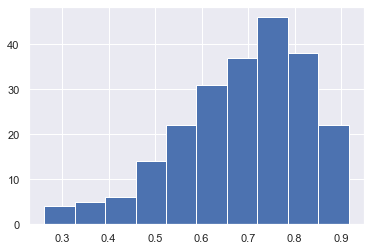

In [43]:
cluster0_bad_clients['proba'].hist().plot()
plt.show()

In [44]:
df_shap.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0      0.003339          0.013248   -0.238087    -0.064474   
1      0.000043          0.002059    0.015116     0.012335   
2      0.000300          0.019465    0.056125     0.027976   
3      0.000274         -0.011925    0.059022     0.019577   
4      0.000020         -0.000380   -0.193231    -0.033418   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                   -0.013918   -0.014371       0.062069          -0.006128   
1                   -0.007406    0.006648      -0.221262          -0.002101   
2                    0.005428    0.096164       0.051760          -0.004211   
3                   -0.013787    0.037835      -0.200787           0.007651   
4                   -0.000718   -0.144271       0.046565          -0.015372   

   DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         0.309703         0.0             0.0        -0.030336   
1        -0.037686         0.0             0.0         0.157598   
2         0.157178         0.0             0.0         0.101022   
3        -0.015874         0.0             0.0        -0.025275   
4        -0.014936         0.0             0.0        -0.033583   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  REGION_RATING_CLIENT  \
0               0.0    0.003115         0.0             -0.015734   
1               0.0   -0.007195         0.0             -0.008488   
2               0.0    0.001980         0.0             -0.018020   
3               0.0    0.001234         0.0             -0.010272   
4               0.0   -0.018092         0.0             -0.012410   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                -0.008850                         0.0   
1                 0.001802                         0.0   
2                -0.000359                         0.0   
3                 0.004342                         0.0   
4                -0.015278                         0.0   

   REG_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
0                   -0.002670                     0.0               -0.027822   
1                   -0.002306                     0.0               -0.000455   
2                   -0.002522                     0.0               -0.012462   
3                   -0.002985                     0.0               -0.005460   
4                   -0.004959                     0.0               -0.007891   

   EXT_SOURCE_2  EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  \
0     -0.139153     -0.708534                 -0.008036   
1     -0.433773     -0.074102                 -0.001833   
2      0.022423      0.069973                 -0.001570   
3     -0.186478     -0.471070                  0.000210   
4     -0.570861      0.102868                 -0.008409   

   DEF_30_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  \
0                 -0.014820               -0.003963              0.0   
1                 -0.028577                0.000658              0.0   
2                 -0.014332               -0.009714              0.0   
3                 -0.007847               -0.012232              0.0   
4                 -0.012219               -0.019226              0.0   

   FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  \
0         0.035405              0.0              0.0              0.0   
1         0.018218              0.0              0.0              0.0   
2        -0.006365              0.0              0.0              0.0   
3         0.034755              0.0              0.0              0.0   
4        -0.004835              0.0              0.0              0.0   

   FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  \
0              0.0              0.0              0.0               0.0   
1              0.0              0.0              0.0               0.0   
2              0.0              0.0              0.0

In [45]:
df_shap.index = y_valid.index

In [46]:
shap_cluster0_bad_clients = df_shap.loc[cluster0_bad_clients.index]
shap_cluster0_bad_clients.head()

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
37286     -0.000195          0.015569   -0.071864     0.005306   
48467      0.000076          0.006298    0.003819    -0.051856   
7753       0.000503          0.006330    0.068598     0.024929   
17804     -0.001177          0.010899    0.037832     0.047984   
22753      0.000280          0.009638   -0.201650    -0.073575   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
37286                    0.014943   -0.001792       0.065549   
48467                   -0.009667    0.018061      -0.122056   
7753                     0.009802    0.059400       0.088360   
17804                    0.000276    0.055967       0.083194   
22753                   -0.000616    0.092004       0.071283   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
37286           0.012198        -0.215484         0.0             0.0   
48467          -0.001661         0.082137         0.0             0.0   
7753           -0.008189        -0.131406         0.0             0.0   
17804           0.000646        -0.074812         0.0             0.0   
22753          -0.003400         0.018583         0.0             0.0   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
37286        -0.023191               0.0    0.001304         0.0   
48467        -0.044871               0.0   -0.017961         0.0   
7753         -0.057873               0.0    0.004791         0.0   
17804        -0.027403               0.0   -0.008167         0.0   
22753        -0.036115               0.0   -0.008127         0.0   

       REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
37286             -0.007292                 0.003659   
48467              0.047408                 0.001251   
7753               0.008536                -0.001488   
17804             -0.014254                 0.005505   
22753             -0.008831                -0.002746   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
37286                         0.0                   -0.000895   
48467                         0.0                   -0.002193   
7753                          0.0                   -0.000686   
17804                         0.0                   -0.004387   
22753                         0.0                   -0.002022   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  \
37286                     0.0               -0.002839     -0.554852   
48467                     0.0               -0.012218      0.096795   
7753                      0.0               -0.002256     -0.127380   
17804                     0.0               -0.013564     -0.211175   
22753                     0.0                0.030837     -0.147453   

       EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
37286      0.588246                  0.001982                 -0.027256   
48467      0.557407                  0.002880                 -0.021175   
7753       0.440280                 -0.004831                 -0.025809   
17804      0.354196                  0.001347                 -0.029598   
22753      0.366471                  0.007891                  0.093911   

       DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  \
37286                0.004769              0.0         0.008488   
48467               -0.018614              0.0         0.005689   
7753                -0.014779              0.0         0.000944   
17804                0.046642              0.0         0.020858   
22753               -0.002195              0.0         0.008245   

       FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  \
37286              0.0              0.0              0.0              0.0   
48467              0.0              0.0              0.0              0.0   
7753               0.0              0.0              0.0              0.0   
17804              0.0              0.0              0.0    

In [84]:
dd = cluster0_bad_clients.iloc[:,:-3]
dd.shape

(225, 572)

In [74]:
dd.to_csv('dd.csv', index=False)

In [79]:
arr = explainer.shap_values(dd)[1]
np.save('arr', arr)

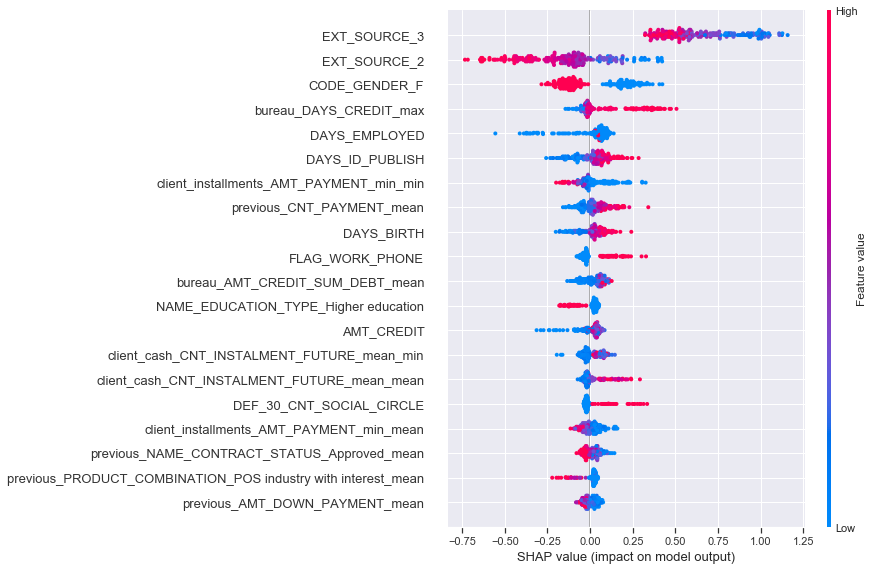

<Figure size 432x288 with 0 Axes>

In [73]:
# summarize the effects of all the features
fig = plt.figure()
shap.summary_plot(explainer.shap_values(dd)[1], dd)
plt.savefig(save_path+'Shap_values_cluster0_bad_clients.png', dpi=200, bbox_inches='tight')
plt.show()

In [64]:
# Add probas (prediction) to the test data
model = 'LGBM'
model_ID = list(models.keys()).index(model)

test_final = test.copy()
test_final['Proba'] = test_proba[model_ID]

In [ ]:
test['CNT_CHILDREN']

In [70]:
# Selection of features we want in the dashboard
data_clients = test_final[['SK_ID_CURR','CODE_GENDER','AMT_CREDIT','AMT_ANNUITY','AMT_INCOME_TOTAL',
                           'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_ID_PUBLISH','bureau_DAYS_CREDIT_max',
                           'EXT_SOURCE_2','EXT_SOURCE_3','FLAG_OWN_CAR','DAYS_REGISTRATION','CNT_CHILDREN',
                           'Proba'
                          ]][:10]

# Rename some features
data_clients = data_clients.rename({'bureau_DAYS_CREDIT_max': 'DAYS_CREDIT_max'}, axis=1)

data_clients

SK_ID_CURR CODE_GENDER  AMT_CREDIT  AMT_ANNUITY  AMT_INCOME_TOTAL  \
0      100001           F    568800.0      20560.5          135000.0   
1      100005           M    222768.0      17370.0           99000.0   
2      100013           M    663264.0      69777.0          202500.0   
3      100028           F   1575000.0      49018.5          315000.0   
4      100038           M    625500.0      32067.0          180000.0   
5      100042           F    959688.0      34600.5          270000.0   
6      100057           M    499221.0      22117.5          180000.0   
7      100065           M    180000.0      14220.0          166500.0   
8      100066           F    364896.0      28957.5          315000.0   
9      100067           F     45000.0       5337.0          162000.0   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_ID_PUBLISH  DAYS_CREDIT_max  EXT_SOURCE_2  \
0      -19241          -2329             -812            -49.0      0.789654   
1      -18064          -4469            -1623            -62.0      0.291656   
2      -20038          -4458            -3503          -1210.0      0.699787   
3      -13976          -1866            -4208           -269.0      0.509677   
4      -13040          -2191            -4262              NaN      0.425687   
5      -18604         -12009            -2027           -234.0      0.628904   
6      -16685          -2580             -241           -337.0      0.571084   
7       -9516          -1387            -2055           -107.0      0.613033   
8      -12744          -1013            -3171           -463.0      0.808788   
9      -10395          -2625            -3041            -57.0      0.444848   

   EXT_SOURCE_3 FLAG_OWN_CAR  DAYS_REGISTRATION  CNT_CHILDREN     Proba  
0      0.159520            N            -5170.0             0  0.228720  
1      0.432962            N            -9118.0             0  0.271906  
2      0.610991            Y            -2175.0             0  0.212671  
3      0.612704            N            -2000.0             2  0.240211  
4           NaN            Y            -4000.0             1  0.313691  
5      0.392774            Y            -6116.0             0  0.216111  
6      0.651260            Y           -10125.0             2  0.292479  
7      0.312365            N            -5063.0             0  0.302688  
8      0.522697            N            -1686.0             0  0.186126  
9      0.194068            Y            -8124.0             1  0.313931

In [71]:
data_clients.to_csv('Fichiers/tab_clients.csv', index=False)